# Coupled model - Intervention

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import model
import pickle
import itertools
import networkx as nx
from itertools import product
from tqdm import tqdm, tqdm_notebook
%matplotlib inline

### Prepare data

In [2]:
prep_data = model.data_and_network_prep()

### Data for fit

In [3]:
# Create data for the fit
data_for_fit_i = model.create_data_for_fit_influenza()

In [4]:
data_for_fit_v = model.create_data_for_fit(prep_data)

### Get Patameters

#### Vaccination model

In [5]:
with open('L:/Dor/Data/vaccination_model/grid_search_5_res.pickle', 'rb') as pickle_in:
    grid_search_res_1 = pickle.load(pickle_in)
    
with open('L:/Dor/Data/vaccination_model/grid_search_6_res.pickle', 'rb') as pickle_in:
    grid_search_res_2 = pickle.load(pickle_in)

with open('L:/Dor/Data/vaccination_model/grid_search_7_res.pickle', 'rb') as pickle_in:
    grid_search_res_3 = pickle.load(pickle_in)
    
    
grid_search_res_v = grid_search_res_1 + grid_search_res_2 + grid_search_res_3
# grid_search_res = grid_search_res_3

In [6]:
# Max likelihood subdist
liklihood_subdist_v = max(grid_search_res_v, key=lambda x: x['log_likelihood_subdist'])

print(f"Max likelihood by subdist: {int(liklihood_subdist_v['log_likelihood_subdist']):,d}")
print(liklihood_subdist_v)

liklihood_subdist_v['parameters']['beta'] = liklihood_subdist_v['parameters']['beta_2'] 

Max likelihood by subdist: 36,129
{'parameters': {'beta_2': 0.016863165243777217, 'delta': 0.278572631507307, 'gamma': 0.19172052098205442, 'I_0_size': 0.001}, 'log_likelihood': -9563.146711506553, 'log_likelihood_age': 197267.18472100564, 'log_likelihood_subdist': 36129.114564781725, 'mse_by_age': 48082.38864520336, 'mse_by_subdist': 926.5220196860498}


In [7]:
parameters_v = liklihood_subdist_v['parameters']

#### Influenza model

In [8]:
# Load parameters_i all seasons
with open('../../data/coupled_model/parameters_i_all_seasons.pickle', 'rb') as pickle_in:
    parameters_i = pickle.load(pickle_in)

In [9]:
parameters_i

{2016: {'beta': 0.001635,
  'phi': -3.7457450869724456,
  'delta': 1,
  'epsilon': 1},
 2011: {'beta': 0.0016, 'phi': -3.9874060603255064, 'delta': 1, 'epsilon': 1},
 2012: {'beta': 0.00145, 'phi': -3.8061603303107105, 'delta': 1, 'epsilon': 1},
 2013: {'beta': 0.00162, 'phi': -3.8424094763136702, 'delta': 1, 'epsilon': 1},
 2014: {'beta': 0.00156, 'phi': -3.9874060603255064, 'delta': 1, 'epsilon': 1},
 2015: {'beta': 0.001525,
  'phi': -3.9269908169872414,
  'delta': 1,
  'epsilon': 1},
 2017: {'beta': 0.001435, 'phi': -3.44366887028112, 'delta': 1, 'epsilon': 1}}

# Intervention

### Intervention parameters

In [283]:
# intervention parameters
length = 5

# Number of simulations
m = 10

Set intervention parameters

In [62]:
pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=167)

Timestamp('2015-11-15 00:00:00')

In [326]:
# Intervention percents
# inter_percents = [0.01, 0.025, 0.05]
# inter_percents = [0.01, 0.02, 0.03, 0.04, 0.05]
inter_percents = [0.005, 0.01, 0.02, 0.03, 0.05]


# Vaccination season start time:  1.8, 1.9, 1.10, 1.11
start_times = [61, 92, 122, 153]
start_times_no_inter = [30, 44, 61, 75, 92, 106, 122, 136, 153, 167, 183]


# Intervention times (by start time)
all_inter_times = [61, 92, 122, 153, 183, 214]  # 1.8, 1.9, 1.10, 1.11, 1.12, 1.1
intervention_times = {61: all_inter_times, 92: all_inter_times[1:], 122: all_inter_times[2:], 153: all_inter_times[3:]}

# Total population size (lamas) - in thousends
total_pop_size = 3606696/1000

## No intervention

In [322]:
with open('../../data/coupled_model/no_intervention_m50.pickle', 'rb') as pickle_in:
    no_inter_res_raw = (pickle.load(pickle_in))

no_inter_res = {}
for d in no_inter_res_raw:
    no_inter_res.update(d)

In [328]:
baseline = min(no_inter_res.items(), key=lambda x: x[1]['attack_rates']['total'])
baseline_attack_rates = {age: baseline[1]['attack_rates'][age] for age in ['children', 'adult_rate', 'total']}
optimal_start_date = pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=baseline[0])
print(f'Optimal vaccination season start date: {optimal_start_date.day}/{optimal_start_date.month}')
print(f'Minimal attack rate: {baseline_attack_rates["total"]*100:.2f}%')
baseline_attack_rates

Optimal vaccination season start date: 1/10
Minimal attack rate: 7.82%


{'children': 0.12061627929860468,
 'adult_rate': 0.06043551253791749,
 'total': 0.078150164954366}

### Plot no intervention

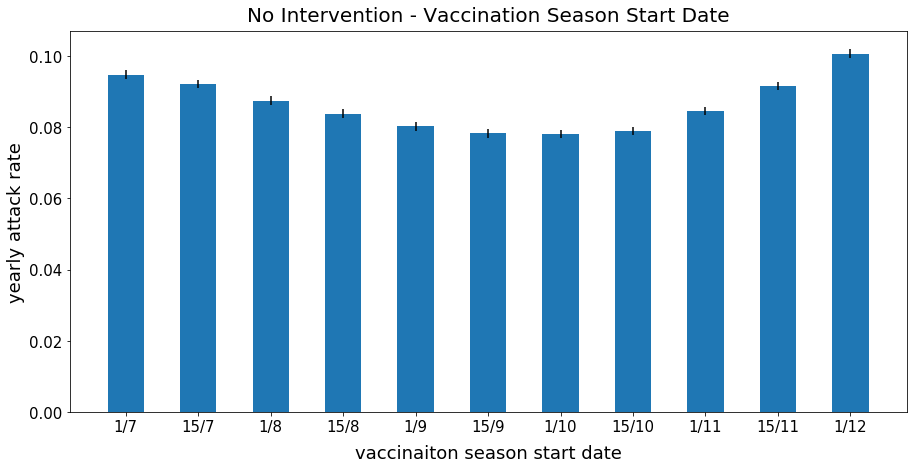

In [332]:
# Get no intervention attack rates
# no_inter_attack_rates = np.array([res['attack_rates']['total'] for res in no_inter_res.values()])
# no_inter_attack_rates_std = np.array([res['attack_rates']['total_std'] for res in no_inter_res.values()])
no_inter_attack_rates = np.array(list(map(lambda x: x[1], sorted([(start_date, res['attack_rates']['total']) for start_date, res in no_inter_res.items()], key=lambda x: x[0]))))
no_inter_attack_rates_std = np.array(list(map(lambda x: x[1], sorted([(start_date, res['attack_rates']['total_std']) for start_date, res in no_inter_res.items()], key=lambda x: x[0]))))

# Convert to cases
no_inter_cases = no_inter_attack_rates*total_pop_size
no_inter_cases_std = np.sqrt((total_pop_size**2)*(no_inter_attack_rates_std**2))

# std
no_inter_attack_rates_std /= np.sqrt(50*len(model.seasons))
no_inter_cases_std /= np.sqrt(50*len(model.seasons))

# Plot attack rates
fig = plt.figure(figsize=(15, 7))

plt.bar(np.arange(11) ,no_inter_attack_rates, width=0.5, yerr=no_inter_attack_rates_std),
#         color=[f'C{i}' for i in range(len(no_inter_attack_rates))])


plt.title('No Intervention - Vaccination Season Start Date', size=20, pad=10)
plt.xlabel('vaccinaiton season start date', size=18, labelpad=10)
plt.ylabel('yearly attack rate', size=18)

start_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in start_times_no_inter]
plt.xticks(np.arange(11), [f'{date.day}/{date.month}' for date in start_dates], size=15)
plt.tick_params('y', labelsize=15)

# Plot cases
# fig = plt.figure(figsize=(15, 7))

# plt.bar(np.arange(11) ,no_inter_cases, width=0.5, yerr=no_inter_cases_std,
#         color=[f'C{i}' for i in range(len(no_inter_attack_rates))])


# plt.title('No Intervention - Vaccination Season Start Date', size=20, pad=10)
# plt.xlabel('vaccinaiton season start date', size=18, labelpad=10)
# plt.ylabel('yearly cases (thousands)', size=18)

# start_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in start_times_no_inter]
# plt.xticks(np.arange(11), [f'{date.day}/{date.month}' for date in start_dates], size=15)
# plt.tick_params('y', labelsize=15)

plt.show()

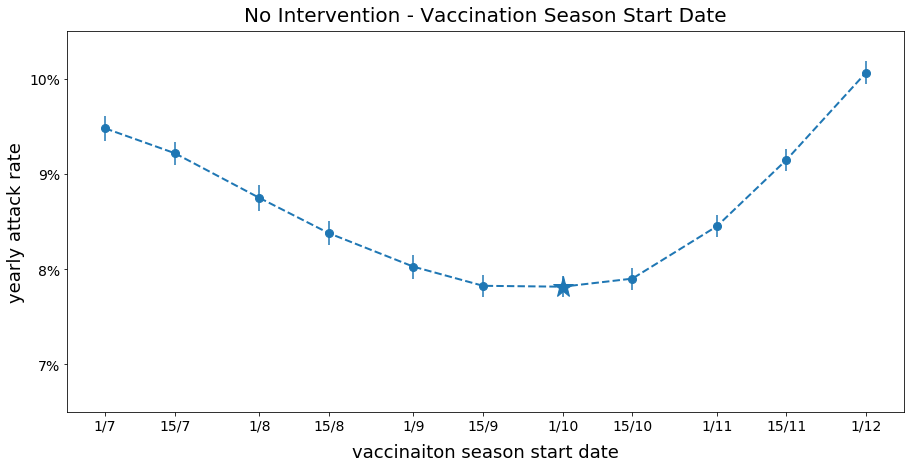

In [338]:
fig = plt.figure(figsize=(15, 7))

# Plot attack rates
plt.plot(start_dates, no_inter_attack_rates, '--o', linewidth=2, markersize=8)

# Plot errors
plt.errorbar(start_dates, no_inter_attack_rates, yerr=no_inter_attack_rates_std, color=f'C0', linestyle='None')

# Mark minimum
plt.plot(optimal_start_date, baseline_attack_rates['total'], '*', color=f'C0', markersize=22)

plt.title('No Intervention - Vaccination Season Start Date', size=20, pad=10)
plt.xlabel('vaccinaiton season start date', size=18, labelpad=10)
plt.ylabel('yearly attack rate', size=18)

plt.xticks(start_dates, [f'{date.day}/{date.month}' for date in start_dates], size=14)
plt.yticks(np.arange(0.07, 0.101, 0.01), [f'{x*100:.0f}%' for x in np.arange(0.07, 0.101, 0.01)], size=14)

plt.ylim([0.065, 0.105])

plt.show()

## Intervention

Load random intervention results

In [284]:
with open('../../data/coupled_model/random_intervention_res_all_seasons_m10_all_per.pickle', 'rb') as pickle_in:
    intervention_restuls_list = pickle.load(pickle_in)
    
# with open('../../data/coupled_model/random_intervention_res_all_seasons_m5.pickle', 'rb') as pickle_in:
#     intervention_restuls_list = pickle.load(pickle_in)
    
# with open('../../data/coupled_model/random_intervention_res_all_seasons_m5_per234.pickle', 'rb') as pickle_in:
#     intervention_restuls_list += pickle.load(pickle_in)
    
intervention_restuls_raw = {}
for d in intervention_restuls_list:
    intervention_restuls_raw.update(d)

# Save to a dict in the correct format
inter_results_random = {inter_percent: {} for inter_percent in inter_percents}
for inter_percent in inter_percents:
    for start_time in start_times:
        res = []
        for inter_time in intervention_times[start_time]:
            res.append(intervention_restuls_raw[(inter_percent, start_time, inter_time)])
        inter_results_random[inter_percent][start_time] = res

Load intervention by subdist results

In [285]:
with open('../../data/coupled_model/subdist_intervention_res_all_seasons_m10_all_per.pickle', 'rb') as pickle_in:
    intervention_restuls_list = pickle.load(pickle_in)

# with open('../../data/coupled_model/subdist_intervention_res_all_seasons_m5.pickle', 'rb') as pickle_in:
#     intervention_restuls_list = pickle.load(pickle_in)

# with open('../../data/coupled_model/subdist_intervention_res_all_seasons_m5_per23.pickle', 'rb') as pickle_in:
#     intervention_restuls_list += pickle.load(pickle_in)
    
# with open('../../data/coupled_model/subdist_intervention_res_all_seasons_m5_per4.pickle', 'rb') as pickle_in:
#     intervention_restuls_list += pickle.load(pickle_in)
    
intervention_restuls_raw = {}
for d in intervention_restuls_list:
    intervention_restuls_raw.update(d)

# Save to a dict in the correct format
inter_results_subdist = {inter_percent: {} for inter_percent in inter_percents}
for inter_percent in inter_percents:
    for start_time in start_times:
        res = []
        for inter_time in intervention_times[start_time]:
            res.append(intervention_restuls_raw[(inter_percent, start_time, inter_time)])
        inter_results_subdist[inter_percent][start_time] = res

Load intervention by yeshuv results

In [286]:
with open('../../data/coupled_model/yeshuv_intervention_res_all_seasons_m10_all_per.pickle', 'rb') as pickle_in:
    intervention_restuls_list = pickle.load(pickle_in)

# with open('../../data/coupled_model/yeshuv_intervention_res_all_seasons_m5.pickle', 'rb') as pickle_in:
#     intervention_restuls_list = pickle.load(pickle_in)
    
# with open('../../data/coupled_model/yeshuv_intervention_res_all_seasons_m5_per23.pickle', 'rb') as pickle_in:
#     intervention_restuls_list += pickle.load(pickle_in)
    
# with open('../../data/coupled_model/yeshuv_intervention_res_all_seasons_m5_per4.pickle', 'rb') as pickle_in:
#     intervention_restuls_list += pickle.load(pickle_in)
    
intervention_restuls_raw = {}
for d in intervention_restuls_list:
    intervention_restuls_raw.update(d)

# Save to a dict in the correct format
inter_results_yeshuv = {inter_percent: {} for inter_percent in inter_percents}
for inter_percent in inter_percents:
    for start_time in start_times:
        res = []
        for inter_time in intervention_times[start_time]:
            res.append(intervention_restuls_raw[(inter_percent, start_time, inter_time)])
        inter_results_yeshuv[inter_percent][start_time] = res

Load intervention by area results

In [133]:
with open('../../data/coupled_model/area_intervention_res_all_seasons_m5.pickle', 'rb') as pickle_in:
    intervention_restuls_list = pickle.load(pickle_in)
            
intervention_restuls_raw = {}
for d in intervention_restuls_list:
    intervention_restuls_raw.update(d)

# Save to a dict in the correct format
inter_results_area = {inter_percent: {} for inter_percent in [0.01, 0.025, 0.05]}
for inter_percent in [0.01, 0.025, 0.05]:
    for start_time in start_times:
        res = []
        for inter_time in intervention_times[start_time]:
            res.append(intervention_restuls_raw[(inter_percent, start_time, inter_time)])
        inter_results_area[inter_percent][start_time] = res

inter_results_area[0.02] = inter_results_area[0.025]
inter_results_area[0.03] = inter_results_area[0.025]
inter_results_area[0.04] = inter_results_area[0.05]

### Attack Rate

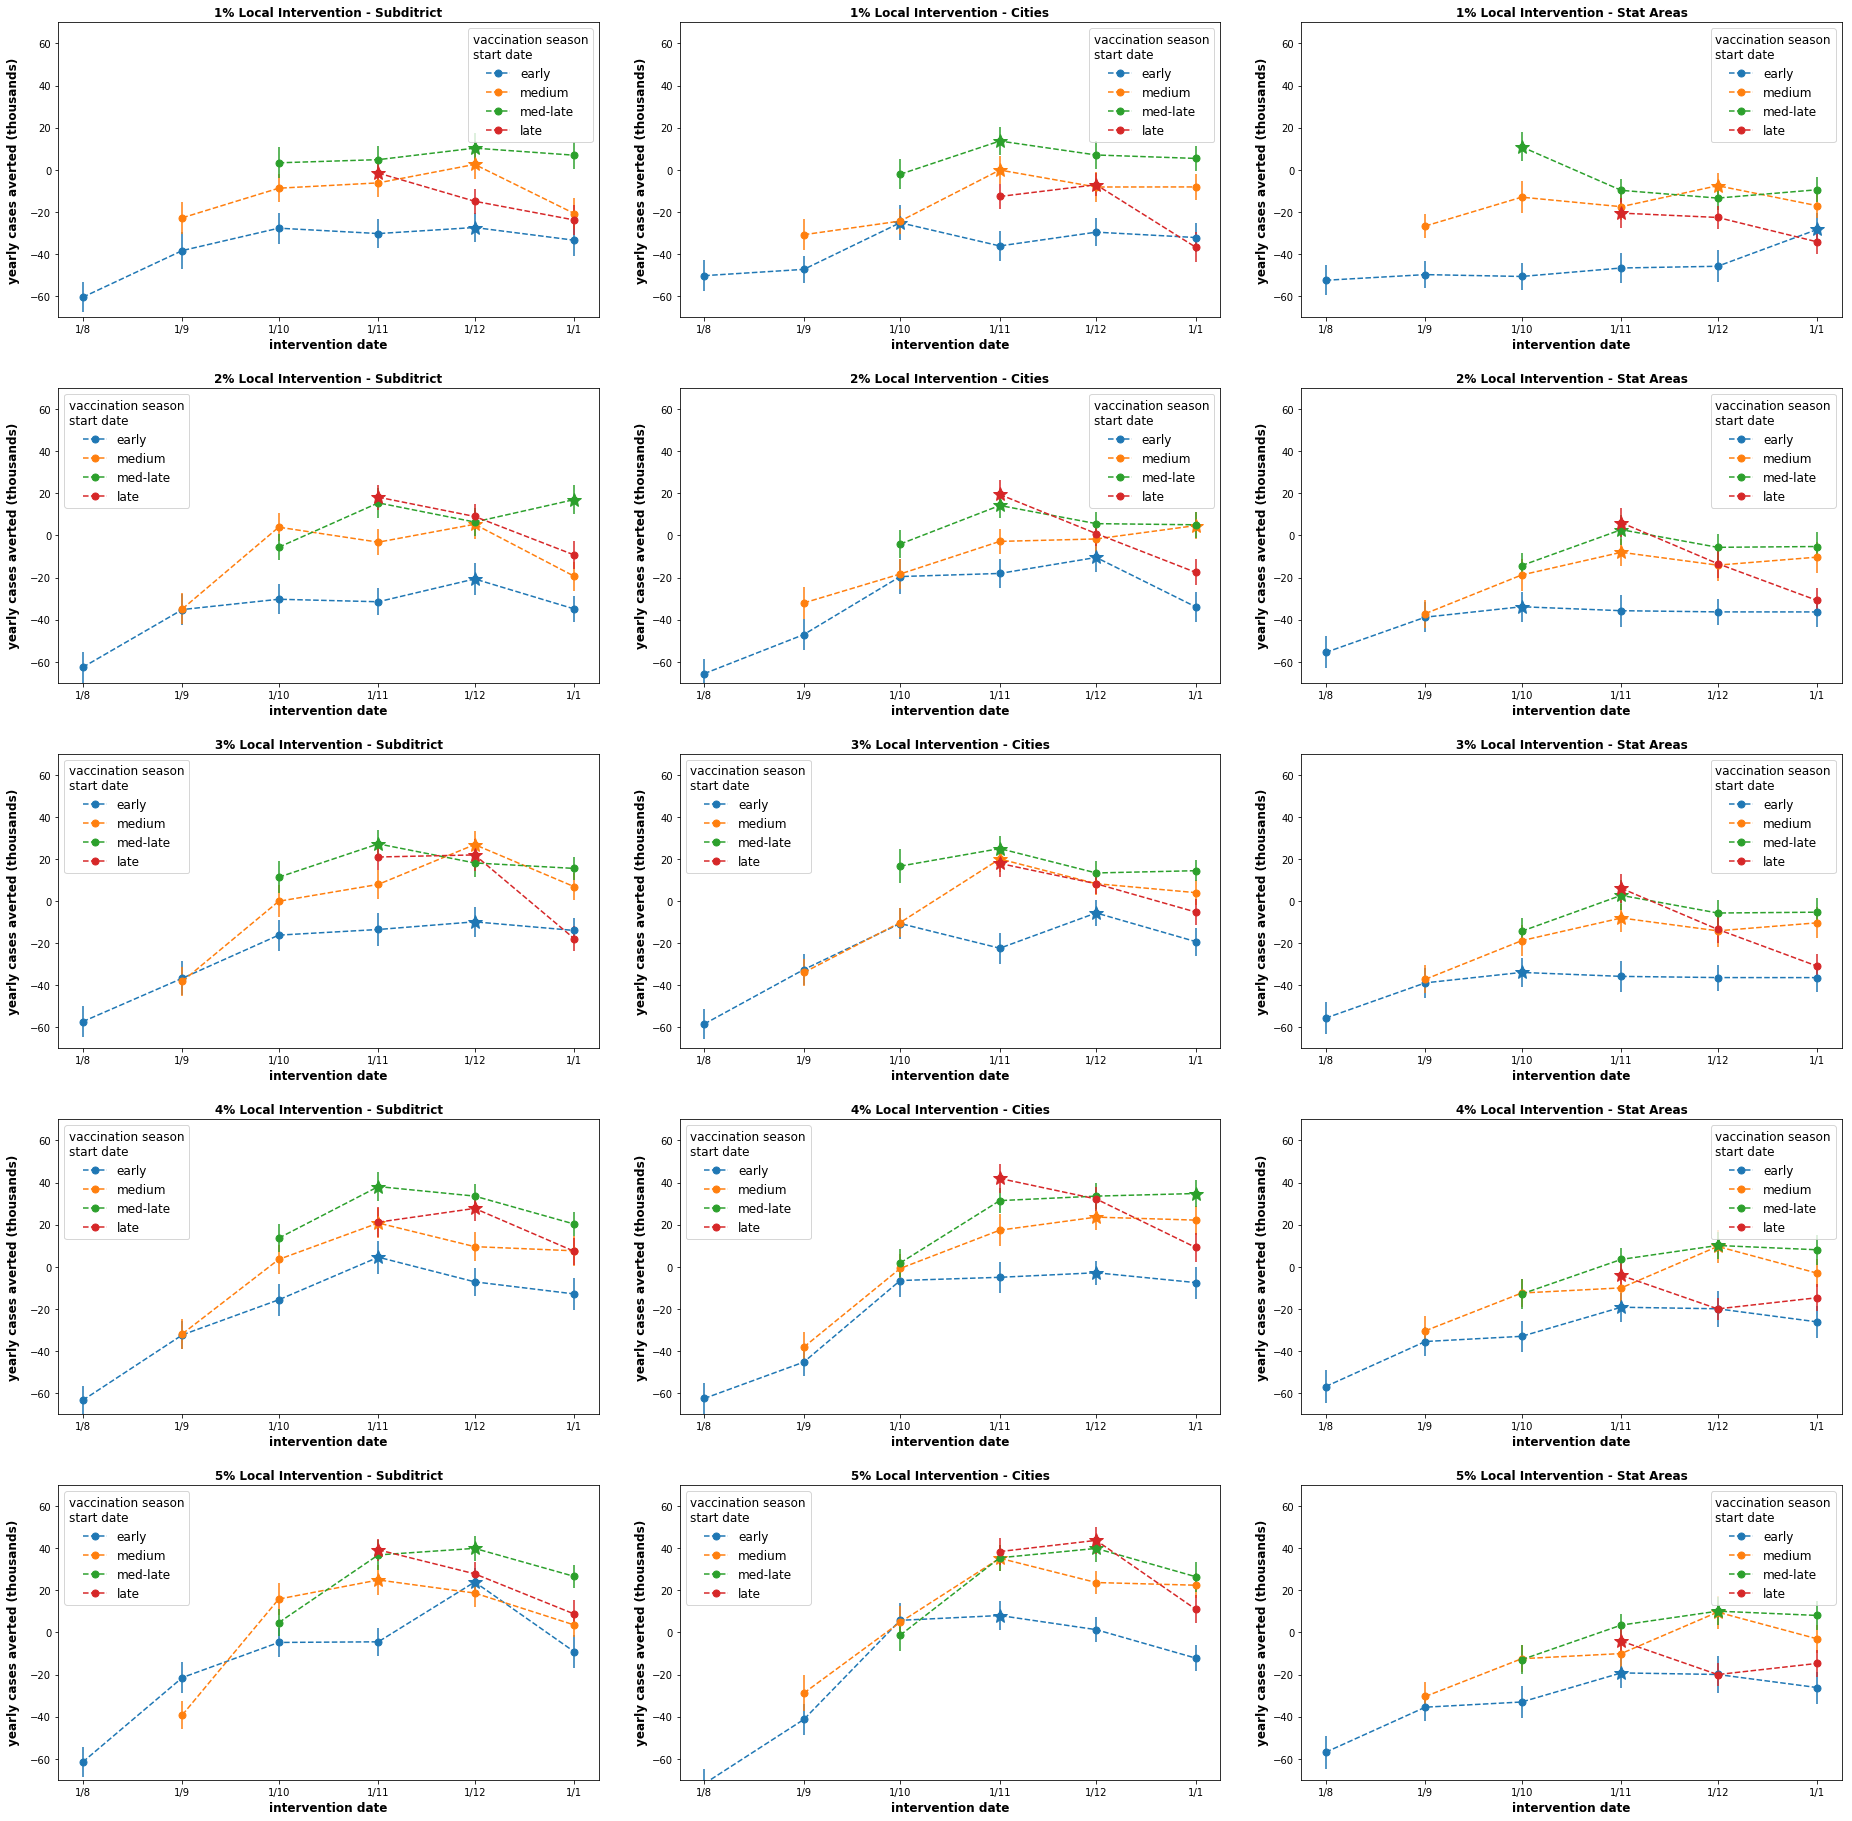

In [136]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(17*1.5, 25))
plt.tight_layout(w_pad=5, h_pad=5)
# ylims = [[-0.035,0.035], [-0.045,0.045], [-0.055,0.055]]
ylims = [[-70,70], [-70,70], [-70,70], [-70,70], [-70,70]]


# Random - global intervention
for j, inter_per in enumerate(inter_percents):
    
    # Get results or current intervention percent
    intevention_res = inter_results_subdist[inter_per]
    
    for i, (start_time, results) in enumerate(intevention_res.items()):
#         # Remove October
#         if start_time == start_times[2]:
#             continue
            
        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_infection_rates = np.array([inter_res['attack_rates']['total'] for inter_res in results])
        inter_infection_rates = baseline_attack_rates['total'] - inter_infection_rates
        # Multiply by population size to get cases averted
        inter_infection_rates *= total_pop_size
        
        # Get errors
        infect_rate_err = np.array([inter_res['attack_rates']['total_std'] for inter_res in results])
        # Adjust std for converting to cases averted
        infect_rate_err = np.sqrt((total_pop_size**2)*(infect_rate_err**2))
        # Divide by sqrt(n)
        infect_rate_err /= np.sqrt(20*len(model.seasons))

        # Plot intervention attack rate
        axs[j,0].plot(inter_dates, inter_infection_rates, '--o', linewidth=1.5, label=['early', 'medium', 'med-late', 'late'][i],
                    color=f'C{i}', markersize=7)
        
        # Mark maximum
        max_idx = np.argmax(inter_infection_rates)
        axs[j,0].plot(inter_dates[max_idx], inter_infection_rates[max_idx], '*', color=f'C{i}', markersize=14)
        
        # Plot errors
        axs[j,0].errorbar(inter_dates, inter_infection_rates, yerr=infect_rate_err, color=f'C{i}', linestyle='None')
        
        axs[j,0].set_title(f'{inter_per*100:.0f}% Local Intervention - Subditrict', size=12, fontweight='bold')
        axs[j,0].set_xlabel('intervention date', size=12, fontweight='bold')
        axs[j,0].set_ylabel('yearly cases averted (thousands)', size=12, fontweight='bold', labelpad=10)
#         axs[j,0].set_ylabel('yearly attack rate change', size=12, fontweight='bold', labelpad=10)

 
        # ticks
        all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
        axs[j,0].set_xticks(all_dates)
        axs[j,0].set_xticklabels([f'{date.day}/{date.month}' for date in all_dates])
        axs[j,0].tick_params(labelsize=10)
        
        axs[j,0].set_ylim(ylims[j])

    
        legend = axs[j,0].legend(fontsize=12, title='vaccination season\nstart date', loc='best')#, loc=(1.01,0.72))
        plt.setp(legend.get_title(), fontsize=12)
        
# By subdists - local intervention
for j, inter_per in enumerate(inter_percents):
    
    # Get results or current intervention percent
    intevention_res = inter_results_yeshuv[inter_per]
    
    for i, (start_time, results) in enumerate(intevention_res.items()):
#         # Remove October
#         if start_time == start_times[2]:
#             continue

        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_infection_rates = np.array([inter_res['attack_rates']['total'] for inter_res in results])
        inter_infection_rates = baseline_attack_rates['total'] - inter_infection_rates
        # Multiply by population size to get cases averted
        inter_infection_rates *= total_pop_size
        
        # Get errors
        infect_rate_err = np.array([inter_res['attack_rates']['total_std'] for inter_res in results])
        # Adjust std for converting to cases averted
        infect_rate_err = np.sqrt((total_pop_size**2)*(infect_rate_err**2))
        # Divide by sqrt(n)
        infect_rate_err /= np.sqrt(20*len(model.seasons))
        
        # Plot intervention attack rate
        axs[j,1].plot(inter_dates, inter_infection_rates, '--o', linewidth=1.5, label=['early', 'medium', 'med-late', 'late'][i],
                    color=f'C{i}', markersize=7)
        
        # Mark maximum
        max_idx = np.argmax(inter_infection_rates)
        axs[j,1].plot(inter_dates[max_idx], inter_infection_rates[max_idx], '*', color=f'C{i}', markersize=14)
        
        # Plot errors
        axs[j,1].errorbar(inter_dates, inter_infection_rates, yerr=infect_rate_err, color=f'C{i}', linestyle='None')

        axs[j,1].set_title(f'{inter_per*100:.0f}% Local Intervention - Cities', size=12, fontweight='bold')
        axs[j,1].set_xlabel('intervention date', size=12, fontweight='bold')
        axs[j,1].set_ylabel('yearly cases averted (thousands)', size=12, fontweight='bold')
        
        # ticks
        all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
        axs[j,1].set_xticks(all_dates)
        axs[j,1].set_xticklabels([f'{date.day}/{date.month}' for date in all_dates])
        axs[j,1].tick_params(labelsize=10)
        
        axs[j,1].set_ylim(ylims[j])

        legend = axs[j,1].legend(fontsize=12, title='vaccination season\nstart date', loc='best')#, loc=(1.01,0.72))
        plt.setp(legend.get_title(), fontsize=12)
        
# By areas - local intervention
for j, inter_per in enumerate(inter_percents):
    
    # Get results or current intervention percent
    intevention_res = inter_results_area[inter_per]
    
    for i, (start_time, results) in enumerate(intevention_res.items()):
#         # Remove October
#         if start_time == start_times[2]:
#             continue
            
        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_infection_rates = np.array([inter_res['attack_rates']['total'] for inter_res in results])
        inter_infection_rates = baseline_attack_rates['total'] - inter_infection_rates
        # Multiply by population size to get cases averted
        inter_infection_rates *= total_pop_size
        
        # Get errors
        infect_rate_err = np.array([inter_res['attack_rates']['total_std'] for inter_res in results])
        # Adjust std for converting to cases averted
        infect_rate_err = np.sqrt((total_pop_size**2)*(infect_rate_err**2))
        # Divide by sqrt(n)
        infect_rate_err /= np.sqrt(20*len(model.seasons))

        # Plot intervention attack rate
        axs[j,2].plot(inter_dates, inter_infection_rates, '--o', linewidth=1.5, label=['early', 'medium', 'med-late', 'late'][i],
                    color=f'C{i}', markersize=7)
        
        # Mark maximum
        max_idx = np.argmax(inter_infection_rates)
        axs[j,2].plot(inter_dates[max_idx], inter_infection_rates[max_idx], '*', color=f'C{i}', markersize=14)
        
        # Plot errors
        axs[j,2].errorbar(inter_dates, inter_infection_rates, yerr=infect_rate_err, color=f'C{i}', linestyle='None')
        
        

        axs[j,2].set_title(f'{inter_per*100:.0f}% Local Intervention - Stat Areas', size=12, fontweight='bold')
        axs[j,2].set_xlabel('intervention date', size=12, fontweight='bold')
        axs[j,2].set_ylabel('yearly cases averted (thousands)', size=12, fontweight='bold')
        
        # ticks
        all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
        axs[j,2].set_xticks(all_dates)
        axs[j,2].set_xticklabels([f'{date.day}/{date.month}' for date in all_dates])
        axs[j,2].tick_params(labelsize=10)
        
        axs[j,2].set_ylim(ylims[j])

    
        legend = axs[j,2].legend(fontsize=12, title='vaccination season\nstart date', loc='best')#, loc=(1.01,0.72))
        plt.setp(legend.get_title(), fontsize=12)

plt.show()

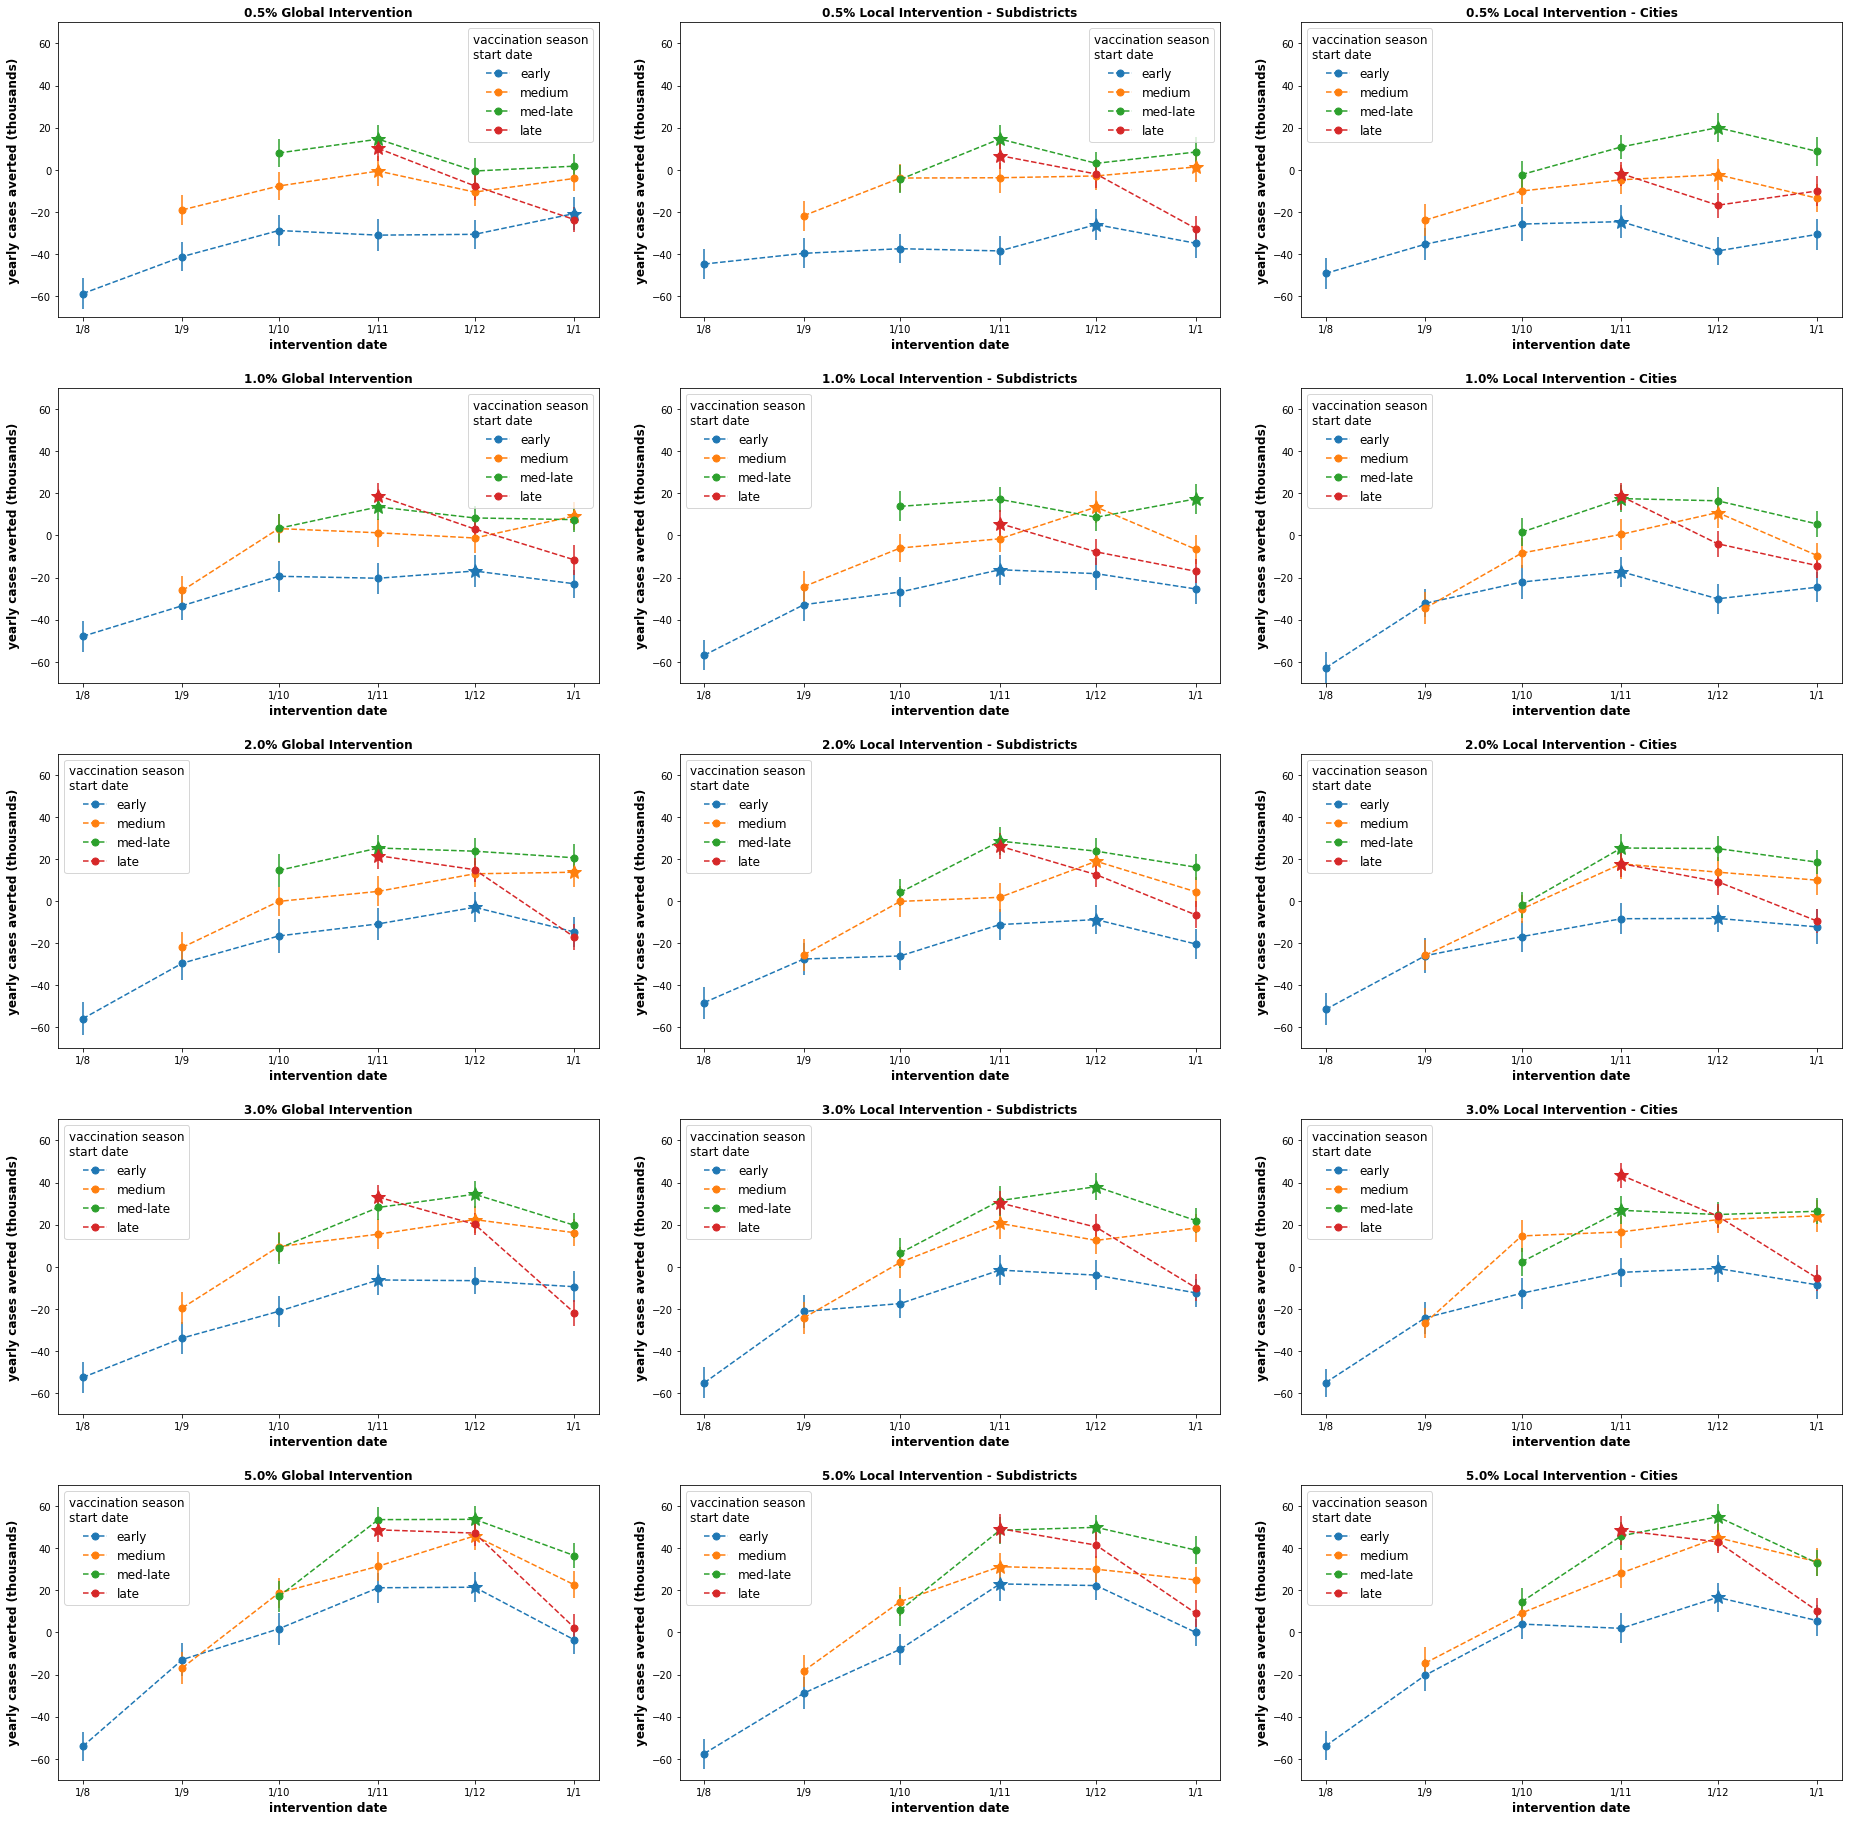

In [345]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(17*1.5, 25))
plt.tight_layout(w_pad=5, h_pad=5)
# ylims = [[-0.035,0.035], [-0.045,0.045], [-0.055,0.055]]
ylims = [[-70,70], [-70,70], [-70,70], [-70,70], [-70,70]]


# Random - global intervention
for j, inter_per in enumerate(inter_percents):
    
    # Get results or current intervention percent
    intevention_res = inter_results_random[inter_per]
    
    for i, (start_time, results) in enumerate(intevention_res.items()):
#         # Remove October
#         if start_time == start_times[2]:
#             continue
            
        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_infection_rates = np.array([inter_res['attack_rates']['total'] for inter_res in results])
        inter_infection_rates = baseline_attack_rates['total'] - inter_infection_rates
        # Multiply by population size to get cases averted
        inter_infection_rates *= total_pop_size
        
        # Get errors
        infect_rate_err = np.array([inter_res['attack_rates']['total_std'] for inter_res in results])
        # Adjust std for converting to cases averted
        infect_rate_err = np.sqrt((total_pop_size**2)*(infect_rate_err**2))
        # Divide by sqrt(n)
        infect_rate_err /= np.sqrt(20*len(model.seasons))

        # Plot intervention attack rate
        axs[j,0].plot(inter_dates, inter_infection_rates, '--o', linewidth=1.5, label=['early', 'medium', 'med-late', 'late'][i],
                    color=f'C{i}', markersize=7)
        
        # Mark maximum
        max_idx = np.argmax(inter_infection_rates)
        axs[j,0].plot(inter_dates[max_idx], inter_infection_rates[max_idx], '*', color=f'C{i}', markersize=14)
        
        # Plot errors
        axs[j,0].errorbar(inter_dates, inter_infection_rates, yerr=infect_rate_err, color=f'C{i}', linestyle='None')
        
        axs[j,0].set_title(f'{inter_per*100:.1f}% Global Intervention', size=12, fontweight='bold')
        axs[j,0].set_xlabel('intervention date', size=12, fontweight='bold')
        axs[j,0].set_ylabel('yearly cases averted (thousands)', size=12, fontweight='bold', labelpad=10)
#         axs[j,0].set_ylabel('yearly attack rate change', size=12, fontweight='bold', labelpad=10)

 
        # ticks
        all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
        axs[j,0].set_xticks(all_dates)
        axs[j,0].set_xticklabels([f'{date.day}/{date.month}' for date in all_dates])
        axs[j,0].tick_params(labelsize=10)
        
        axs[j,0].set_ylim(ylims[j])

    
        legend = axs[j,0].legend(fontsize=12, title='vaccination season\nstart date', loc='best')#, loc=(1.01,0.72))
        plt.setp(legend.get_title(), fontsize=12)
        
# By yeshuv - local intervention
for j, inter_per in enumerate(inter_percents):
    
    # Get results or current intervention percent
    intevention_res = inter_results_subdist[inter_per]
    
    for i, (start_time, results) in enumerate(intevention_res.items()):
#         # Remove October
#         if start_time == start_times[2]:
#             continue
            
        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_infection_rates = np.array([inter_res['attack_rates']['total'] for inter_res in results])
        inter_infection_rates = baseline_attack_rates['total'] - inter_infection_rates
        # Multiply by population size to get cases averted
        inter_infection_rates *= total_pop_size
        
        # Get errors
        infect_rate_err = np.array([inter_res['attack_rates']['total_std'] for inter_res in results])
        # Adjust std for converting to cases averted
        infect_rate_err = np.sqrt((total_pop_size**2)*(infect_rate_err**2))
        # Divide by sqrt(n)
        infect_rate_err /= np.sqrt(20*len(model.seasons))
        
        # Plot intervention attack rate
        axs[j,1].plot(inter_dates, inter_infection_rates, '--o', linewidth=1.5, label=['early', 'medium', 'med-late', 'late'][i],
                    color=f'C{i}', markersize=7)
        
        # Mark maximum
        max_idx = np.argmax(inter_infection_rates)
        axs[j,1].plot(inter_dates[max_idx], inter_infection_rates[max_idx], '*', color=f'C{i}', markersize=14)
        
        # Plot errors
        axs[j,1].errorbar(inter_dates, inter_infection_rates, yerr=infect_rate_err, color=f'C{i}', linestyle='None')

        axs[j,1].set_title(f'{inter_per*100:.1f}% Local Intervention - Subdistricts', size=12, fontweight='bold')
        axs[j,1].set_xlabel('intervention date', size=12, fontweight='bold')
        axs[j,1].set_ylabel('yearly cases averted (thousands)', size=12, fontweight='bold')
        
        # ticks
        all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
        axs[j,1].set_xticks(all_dates)
        axs[j,1].set_xticklabels([f'{date.day}/{date.month}' for date in all_dates])
        axs[j,1].tick_params(labelsize=10)
        
        axs[j,1].set_ylim(ylims[j])

        legend = axs[j,1].legend(fontsize=12, title='vaccination season\nstart date', loc='best')#, loc=(1.01,0.72))
        plt.setp(legend.get_title(), fontsize=12)
        
          
# By areas - local intervention
for j, inter_per in enumerate(inter_percents):
    
    # Get results or current intervention percent
    intevention_res = inter_results_yeshuv[inter_per]
    
    for i, (start_time, results) in enumerate(intevention_res.items()):
#         # Remove October
#         if start_time == start_times[2]:
#             continue

        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_infection_rates = np.array([inter_res['attack_rates']['total'] for inter_res in results])
        inter_infection_rates = baseline_attack_rates['total'] - inter_infection_rates
        # Multiply by population size to get cases averted
        inter_infection_rates *= total_pop_size
        
        # Get errors
        infect_rate_err = np.array([inter_res['attack_rates']['total_std'] for inter_res in results])
        # Adjust std for converting to cases averted
        infect_rate_err = np.sqrt((total_pop_size**2)*(infect_rate_err**2))
        # Divide by sqrt(n)
        infect_rate_err /= np.sqrt(20*len(model.seasons))

        # Plot intervention attack rate
        axs[j,2].plot(inter_dates, inter_infection_rates, '--o', linewidth=1.5, label=['early', 'medium', 'med-late', 'late'][i],
                    color=f'C{i}', markersize=7)
        
        # Mark maximum
        max_idx = np.argmax(inter_infection_rates)
        axs[j,2].plot(inter_dates[max_idx], inter_infection_rates[max_idx], '*', color=f'C{i}', markersize=14)
        
        # Plot errors
        axs[j,2].errorbar(inter_dates, inter_infection_rates, yerr=infect_rate_err, color=f'C{i}', linestyle='None')
        
        

        axs[j,2].set_title(f'{inter_per*100:.1f}% Local Intervention - Cities', size=12, fontweight='bold')
        axs[j,2].set_xlabel('intervention date', size=12, fontweight='bold')
        axs[j,2].set_ylabel('yearly cases averted (thousands)', size=12, fontweight='bold')
        
        # ticks
        all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
        axs[j,2].set_xticks(all_dates)
        axs[j,2].set_xticklabels([f'{date.day}/{date.month}' for date in all_dates])
        axs[j,2].tick_params(labelsize=10)
        
        axs[j,2].set_ylim(ylims[j])

    
        legend = axs[j,2].legend(fontsize=12, title='vaccination season\nstart date', loc='best')#, loc=(1.01,0.72))
        plt.setp(legend.get_title(), fontsize=12)
plt.show()

### Optimal strategies

In [339]:
m = 10

random intervention

In [340]:
# Get minimum attack rate for each intervention percent for each start time
min_rates = {inter_per: [(start_time, min(res, key=lambda x: x['attack_rates']['total']), res.index(min(res, key=lambda x: x['attack_rates']['total'])))
             for start_time, res in results.items()]
             for inter_per, results in inter_results_random.items()}

# Get minimum attack rate for each intervention percent
min_rates_final_random = {inter_per: min(mins, key=lambda x: x[1]['attack_rates']['total'])
                          for inter_per, mins in min_rates.items()}

# Save as dict: {inter_percent: (start_time, intervention time, attack rate, attack rate std)}
min_rates_final_random = {inter_per: (mins[0], mins[2], mins[1]['attack_rates']['total'], mins[1]['attack_rates']['total_std'])
                          for inter_per, mins in min_rates_final_random.items()}

# Convert to cases averted
max_averted_random = {inter_per: (mins[0], mins[1], (baseline_attack_rates['total'] - mins[2])*total_pop_size,
                                  np.sqrt((total_pop_size**2)*(mins[3]**2))/np.sqrt(m*len(model.seasons)))
                      for inter_per, mins in min_rates_final_random.items()}

max_averted_random

{0.005: (122, 1, 14.535659633132138, 9.213211170036466),
 0.01: (153, 0, 18.914921330409737, 8.79152454168009),
 0.02: (122, 1, 25.22369074592967, 8.439121892815209),
 0.03: (122, 2, 34.45649486819584, 9.00902194793143),
 0.05: (122, 2, 53.74112533855465, 9.151308133158576)}

Subdist intervnetion

In [341]:
# Get minimum attack rate for each intervention percent for each start time
min_rates = {inter_per: [(start_time, min(res, key=lambda x: x['attack_rates']['total']), res.index(min(res, key=lambda x: x['attack_rates']['total'])))
             for start_time, res in results.items()]
             for inter_per, results in inter_results_subdist.items()}

# Get minimum attack rate for each intervention percent
min_rates_final_subdist = {inter_per: min(mins, key=lambda x: x[1]['attack_rates']['total'])
                          for inter_per, mins in min_rates.items()}

# Save as dict: {inter_percent: (start_time, intervention time, attack rate, attack rate std)}
min_rates_final_subdist = {inter_per: (mins[0], mins[2], mins[1]['attack_rates']['total'], mins[1]['attack_rates']['total_std'])
                          for inter_per, mins in min_rates_final_subdist.items()}


# Convert to cases averted
max_averted_subdist = {inter_per: (mins[0], mins[1], (baseline_attack_rates['total'] - mins[2])*total_pop_size,
                                   np.sqrt((total_pop_size**2)*(mins[3]**2))/np.sqrt(m*len(model.seasons)))
                       for inter_per, mins in min_rates_final_subdist.items()}

max_averted_subdist

{0.005: (122, 1, 14.63385872653484, 9.150275361905617),
 0.01: (122, 3, 17.341646493553867, 10.043111405266881),
 0.02: (122, 1, 28.510748696903903, 9.429351350085662),
 0.03: (122, 2, 38.0893389884923, 8.968780404176973),
 0.05: (122, 2, 49.95210287289964, 8.191299609286448)}

Yeshuv intervention

In [342]:
# Get minimum attack rate for each intervention percent for each start time
min_rates = {inter_per: [(start_time, min(res, key=lambda x: x['attack_rates']['total']), res.index(min(res, key=lambda x: x['attack_rates']['total'])))
             for start_time, res in results.items()]
             for inter_per, results in inter_results_yeshuv.items()}

# Get minimum attack rate for each intervention percent
min_rates_final_yeshuv = {inter_per: min(mins, key=lambda x: x[1]['attack_rates']['total'])
                        for inter_per, mins in min_rates.items()}

# Save as dict: {inter_percent: (start_time, intervention time, attack rate, attack rate std)}
min_rates_final_yeshuv = {inter_per: (mins[0], mins[2], mins[1]['attack_rates']['total'], mins[1]['attack_rates']['total_std'])
                        for inter_per, mins in min_rates_final_yeshuv.items()}

# Convert to cases averted
max_averted_yeshuv = {inter_per: (mins[0], mins[1], (baseline_attack_rates['total'] - mins[2])*total_pop_size,
                                np.sqrt((total_pop_size**2)*(mins[3]**2))/np.sqrt(m*len(model.seasons)))
                    for inter_per, mins in min_rates_final_yeshuv.items()}

max_averted_yeshuv

{0.005: (122, 2, 20.03115251446065, 9.501958248709478),
 0.01: (153, 0, 18.591073256422213, 8.989115455401485),
 0.02: (122, 1, 25.21324403386548, 9.700423559588133),
 0.03: (153, 0, 43.522673933039265, 8.31469844825666),
 0.05: (122, 2, 54.97018101289796, 8.797492029125612)}

Areas intervention

In [343]:
# Get minimum attack rate for each intervention percent for each start time
min_rates = {inter_per: [(start_time, min(res, key=lambda x: x['attack_rates']['total']), res.index(min(res, key=lambda x: x['attack_rates']['total'])))
             for start_time, res in results.items()]
             for inter_per, results in inter_results_area.items()}

# Get minimum attack rate for each intervention percent
min_rates_final_area = {inter_per: min(mins, key=lambda x: x[1]['attack_rates']['total'])
                        for inter_per, mins in min_rates.items()}

# Save as dict: {inter_percent: (start_time, intervention time, attack rate, attack rate std)}
min_rates_final_area = {inter_per: (mins[0], mins[2], mins[1]['attack_rates']['total'], mins[1]['attack_rates']['total_std'])
                        for inter_per, mins in min_rates_final_area.items()}

# Convert to cases averted
max_averted_area = {inter_per: (mins[0], mins[1], (baseline_attack_rates['total'] - mins[2])*total_pop_size,
                                np.sqrt((total_pop_size**2)*(mins[3]**2))/np.sqrt(m*len(model.seasons)))
                    for inter_per, mins in min_rates_final_area.items()}

max_averted_area.pop(0.025)
max_averted_area

{0.01: (122, 0, 19.053862600862523, 9.76366577049285),
 0.05: (122, 2, 18.286029264150017, 9.199198597540974),
 0.02: (153, 0, 14.24001768171776, 9.820143348594396),
 0.03: (153, 0, 14.24001768171776, 9.820143348594396),
 0.04: (122, 2, 18.286029264150017, 9.199198597540974)}

#### Plot optimal strategies

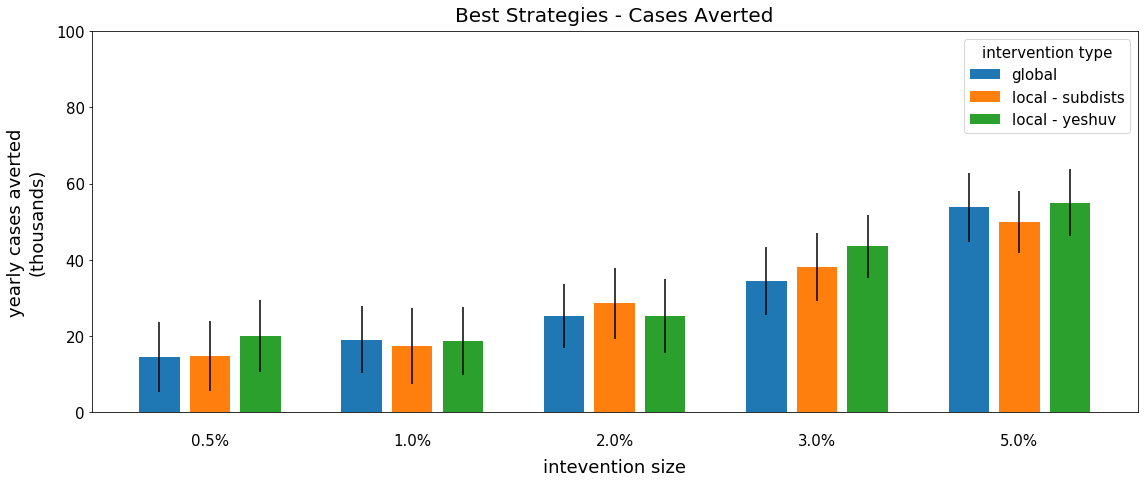

In [344]:
max_averted = [max_averted_random, max_averted_subdist, max_averted_yeshuv]#, max_averted_area]
max_averted_labels = ['global', 'local - subdists', 'local - yeshuv']#, 'local - stat areas']

fig = plt.figure(figsize=(15*1.25, 7))

for i, maxs in enumerate(max_averted):
    plt.bar(np.arange(0+i, 17+i, 4), [maxs[inter_percent][2] for inter_percent in inter_percents], color=f'C{i}',
            yerr=[maxs[inter_percent][3] for inter_percent in inter_percents], label=max_averted_labels[i])
    
legend = plt.legend(fontsize=15, title='intervention type')
plt.setp(legend.get_title(), fontsize=15)

plt.title('Best Strategies - Cases Averted', size=20, pad=10)
plt.xlabel('intevention size', size=18, labelpad=10)
plt.ylabel('yearly cases averted\n(thousands)', size=18, labelpad=10)

plt.xticks(np.arange(0+1, 17.5+1, 4), [f'\n{inter_percent*100:.1f}%' for inter_percent in inter_percents], size=15)
plt.tick_params(axis='x', which='both',length=0)
plt.tick_params(axis='y', labelsize=15)

plt.ylim([0,100])

plt.show()

### Vaccination Coverage

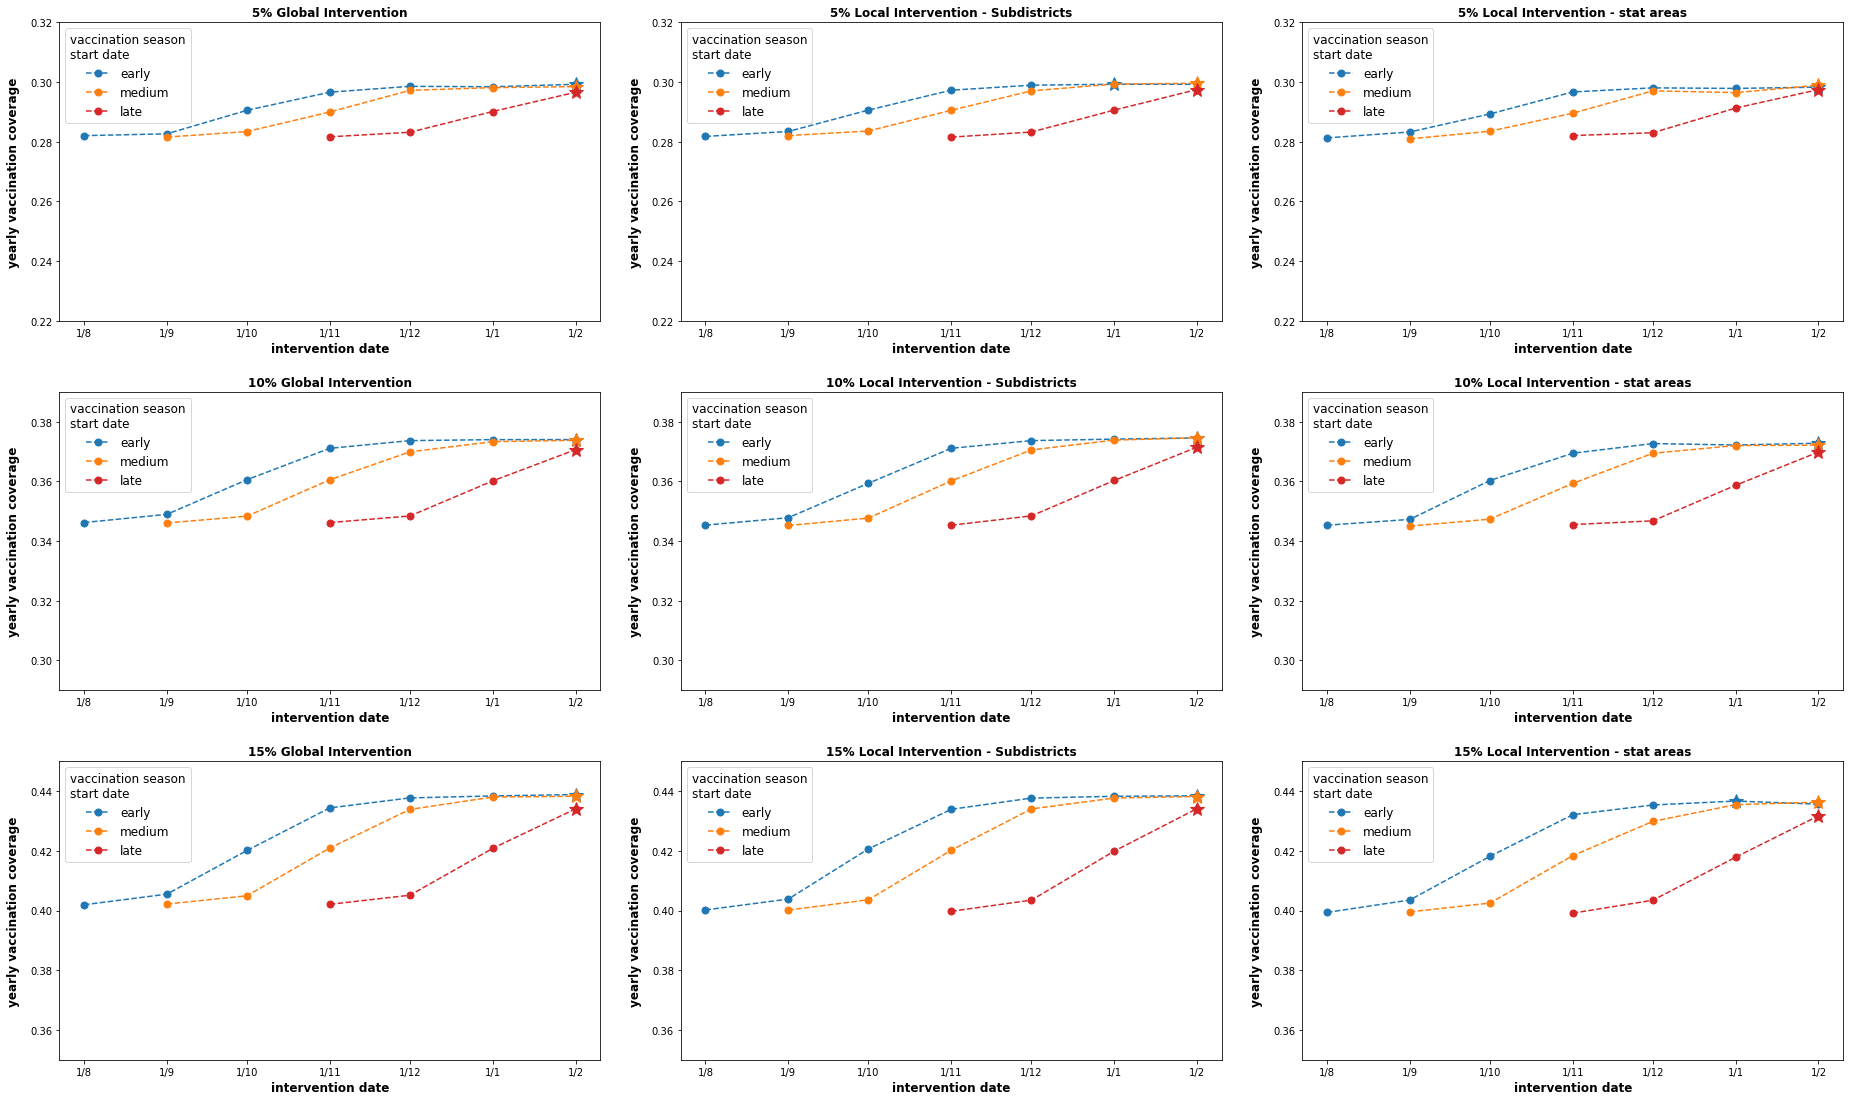

In [111]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(17*1.5, 15))
plt.tight_layout(w_pad=5, h_pad=5)
ylims = [[0.22, 0.32], [0.29, 0.39], [0.35, 0.45]]

# Random - global intervention
for j, (inter_per, intevention_res) in enumerate(inter_results_random.items()):
    
    for i, (start_time, results) in enumerate(intevention_res.items()):
        # Remove October
        if start_time == start_times[2]:
            continue
            
        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_vacc_coverage = np.array([inter_res['vacc_coverages']['total'] for inter_res in results])
        # Get errors
        coverage_err = np.array([inter_res['vacc_coverages']['total_std'] for inter_res in results]) / np.sqrt(20*len(model.seasons))

        # Plot intervention attack rate
        axs[j,0].plot(inter_dates, inter_vacc_coverage, '--o', linewidth=1.5, label=['early', 'medium', 0, 'late'][i],
                    color=f'C{i}', markersize=7)
        
        # Mark maximum
        max_idx = np.argmax(inter_vacc_coverage)
        axs[j,0].plot(inter_dates[max_idx], inter_vacc_coverage[max_idx], '*', color=f'C{i}', markersize=14)
        
        # Plot errors
        axs[j,0].errorbar(inter_dates, inter_vacc_coverage, yerr=coverage_err, color=f'C{i}', linestyle='None')
        
        axs[j,0].set_title(f'{inter_per*100:.0f}% Global Intervention', size=12, fontweight='bold')
        axs[j,0].set_xlabel('intervention date', size=12, fontweight='bold')
        axs[j,0].set_ylabel('yearly vaccination coverage', size=12, fontweight='bold', labelpad=10)
  
        # ticks
        all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
        axs[j,0].set_xticks(all_dates)
        axs[j,0].set_xticklabels([f'{date.day}/{date.month}' for date in all_dates])
        axs[j,0].tick_params(labelsize=10)
        
        axs[j,0].set_ylim(ylims[j])

    
        legend = axs[j,0].legend(fontsize=12, title='vaccination season\nstart date', loc='upper left')#, loc=(1.01,0.72))
        plt.setp(legend.get_title(), fontsize=12)
        
# By areas - local intervention
for j, (inter_per, intevention_res) in enumerate(inter_results_subdist.items()):
    
       for i, (start_time, results) in enumerate(intevention_res.items()):
        # Remove October
        if start_time == start_times[2]:
            continue
            
        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_vacc_coverage = np.array([inter_res['vacc_coverages']['total'] for inter_res in results])
        # Get errors
        coverage_err = np.array([inter_res['vacc_coverages']['total_std'] for inter_res in results]) / np.sqrt(20*len(model.seasons))

        # Plot intervention attack rate
        axs[j,1].plot(inter_dates, inter_vacc_coverage, '--o', linewidth=1.5, label=['early', 'medium', 0, 'late'][i],
                    color=f'C{i}', markersize=7)
        
        # Mark maximum
        max_idx = np.argmax(inter_vacc_coverage)
        axs[j,1].plot(inter_dates[max_idx], inter_vacc_coverage[max_idx], '*', color=f'C{i}', markersize=14)
        
        # Plot errors
        axs[j,1].errorbar(inter_dates, inter_vacc_coverage, yerr=coverage_err, color=f'C{i}', linestyle='None')
        

        axs[j,1].set_title(f'{inter_per*100:.0f}% Local Intervention - Subdistricts', size=12, fontweight='bold')
        axs[j,1].set_xlabel('intervention date', size=12, fontweight='bold')
        axs[j,1].set_ylabel('yearly vaccination coverage', size=12, fontweight='bold', labelpad=10)

        
        # ticks
        all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
        axs[j,1].set_xticks(all_dates)
        axs[j,1].set_xticklabels([f'{date.day}/{date.month}' for date in all_dates])
        axs[j,1].tick_params(labelsize=10)
        
        axs[j,1].set_ylim(ylims[j])

    
        legend = axs[j,1].legend(fontsize=12, title='vaccination season\nstart date', loc='upper left')#, loc=(1.01,0.72))
        plt.setp(legend.get_title(), fontsize=12)
        
# By areas - local intervention
for j, (inter_per, intevention_res) in enumerate(inter_results_yeshuv.items()):
    
       for i, (start_time, results) in enumerate(intevention_res.items()):
        # Remove October
        if start_time == start_times[2]:
            continue
            
        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_vacc_coverage = np.array([inter_res['vacc_coverages']['total'] for inter_res in results])
        # Get errors
        coverage_err = np.array([inter_res['vacc_coverages']['total_std'] for inter_res in results]) / np.sqrt(20*len(model.seasons))

        # Plot intervention attack rate
        axs[j,2].plot(inter_dates, inter_vacc_coverage, '--o', linewidth=1.5, label=['early', 'medium', 0, 'late'][i],
                    color=f'C{i}', markersize=7)
        
        # Mark maximum
        max_idx = np.argmax(inter_vacc_coverage)
        axs[j,2].plot(inter_dates[max_idx], inter_vacc_coverage[max_idx], '*', color=f'C{i}', markersize=14)
        
        # Plot errors
        axs[j,2].errorbar(inter_dates, inter_vacc_coverage, yerr=coverage_err, color=f'C{i}', linestyle='None')
        

        axs[j,2].set_title(f'{inter_per*100:.0f}% Local Intervention - stat areas', size=12, fontweight='bold')
        axs[j,2].set_xlabel('intervention date', size=12, fontweight='bold')
        axs[j,2].set_ylabel('yearly vaccination coverage', size=12, fontweight='bold', labelpad=10)

        
        # ticks
        all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
        axs[j,2].set_xticks(all_dates)
        axs[j,2].set_xticklabels([f'{date.day}/{date.month}' for date in all_dates])
        axs[j,2].tick_params(labelsize=10)
        
        axs[j,2].set_ylim(ylims[j])

    
        legend = axs[j,2].legend(fontsize=12, title='vaccination season\nstart date', loc='upper left')#, loc=(1.01,0.72))
        plt.setp(legend.get_title(), fontsize=12)

plt.show()

#### Global and yeshuv - vaccination coverage

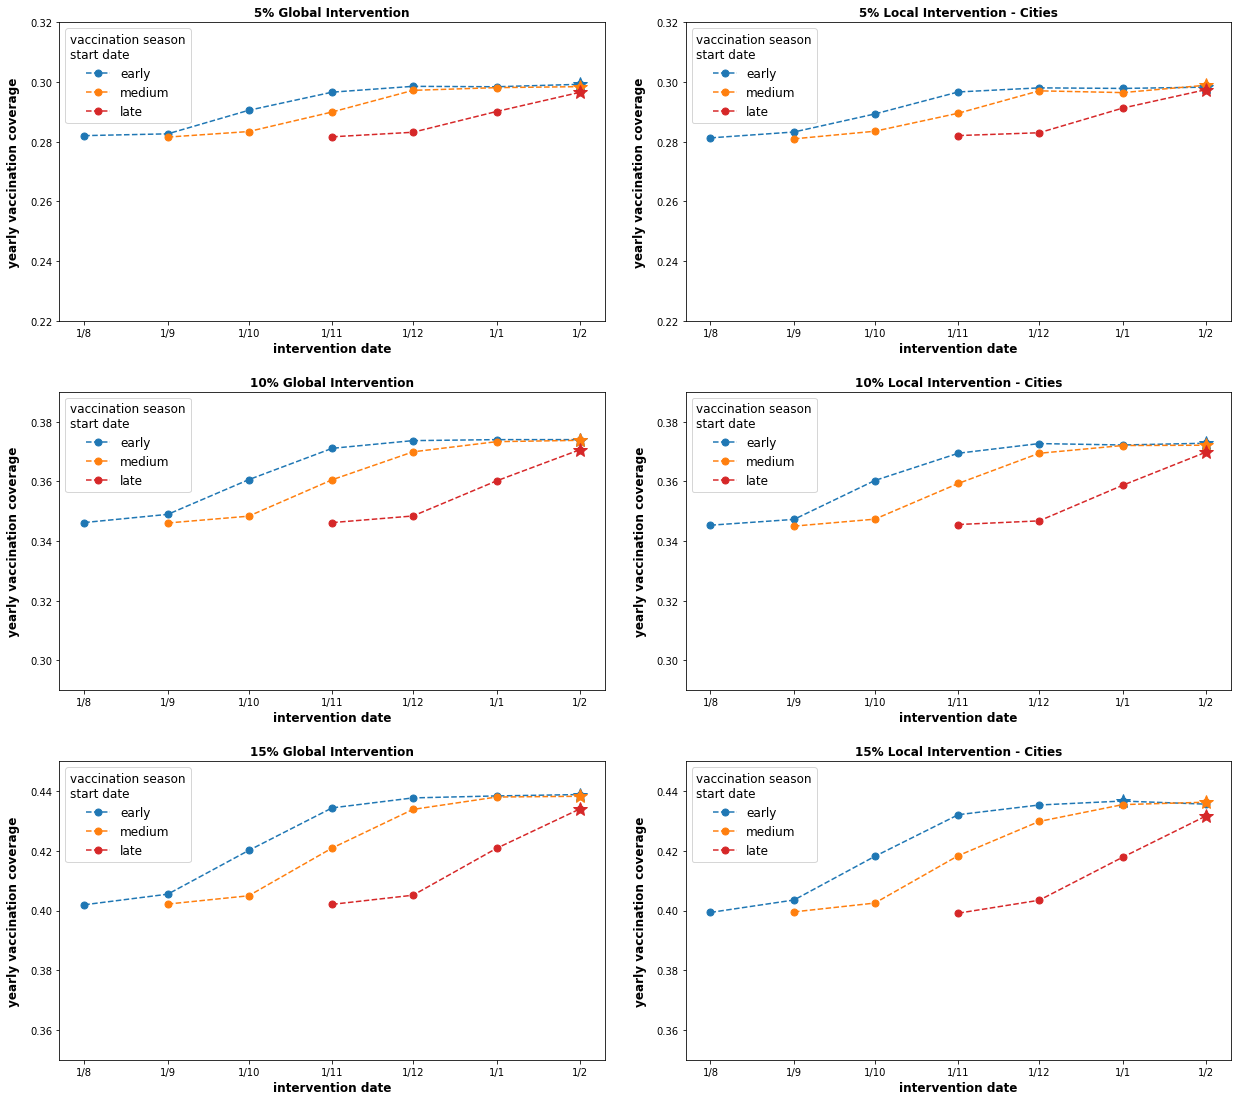

In [112]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(17, 15))
plt.tight_layout(w_pad=5, h_pad=5)
ylims = [[0.22, 0.32], [0.29, 0.39], [0.35, 0.45]]

# Random - global intervention
for j, (inter_per, intevention_res) in enumerate(inter_results_random.items()):
    
    for i, (start_time, results) in enumerate(intevention_res.items()):
        # Remove October
        if start_time == start_times[2]:
            continue
            
        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_vacc_coverage = np.array([inter_res['vacc_coverages']['total'] for inter_res in results])
        # Get errors
        coverage_err = np.array([inter_res['vacc_coverages']['total_std'] for inter_res in results]) / np.sqrt(20*len(model.seasons))

        # Plot intervention attack rate
        axs[j,0].plot(inter_dates, inter_vacc_coverage, '--o', linewidth=1.5, label=['early', 'medium', 0, 'late'][i],
                    color=f'C{i}', markersize=7)
        
        # Mark maximum
        max_idx = np.argmax(inter_vacc_coverage)
        axs[j,0].plot(inter_dates[max_idx], inter_vacc_coverage[max_idx], '*', color=f'C{i}', markersize=14)
        
        # Plot errors
        axs[j,0].errorbar(inter_dates, inter_vacc_coverage, yerr=coverage_err, color=f'C{i}', linestyle='None')
        
        axs[j,0].set_title(f'{inter_per*100:.0f}% Global Intervention', size=12, fontweight='bold')
        axs[j,0].set_xlabel('intervention date', size=12, fontweight='bold')
        axs[j,0].set_ylabel('yearly vaccination coverage', size=12, fontweight='bold', labelpad=10)
  
        # ticks
        all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
        axs[j,0].set_xticks(all_dates)
        axs[j,0].set_xticklabels([f'{date.day}/{date.month}' for date in all_dates])
        axs[j,0].tick_params(labelsize=10)
        
        axs[j,0].set_ylim(ylims[j])

    
        legend = axs[j,0].legend(fontsize=12, title='vaccination season\nstart date', loc='upper left')#, loc=(1.01,0.72))
        plt.setp(legend.get_title(), fontsize=12)
        
# By yeshuv - local intervention
for j, (inter_per, intevention_res) in enumerate(inter_results_yeshuv.items()):
    
       for i, (start_time, results) in enumerate(intevention_res.items()):
        # Remove October
        if start_time == start_times[2]:
            continue
            
        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_vacc_coverage = np.array([inter_res['vacc_coverages']['total'] for inter_res in results])
        # Get errors
        coverage_err = np.array([inter_res['vacc_coverages']['total_std'] for inter_res in results]) / np.sqrt(20*len(model.seasons))

        # Plot intervention attack rate
        axs[j,1].plot(inter_dates, inter_vacc_coverage, '--o', linewidth=1.5, label=['early', 'medium', 0, 'late'][i],
                    color=f'C{i}', markersize=7)
        
        # Mark maximum
        max_idx = np.argmax(inter_vacc_coverage)
        axs[j,1].plot(inter_dates[max_idx], inter_vacc_coverage[max_idx], '*', color=f'C{i}', markersize=14)
        
        # Plot errors
        axs[j,1].errorbar(inter_dates, inter_vacc_coverage, yerr=coverage_err, color=f'C{i}', linestyle='None')
        

        axs[j,1].set_title(f'{inter_per*100:.0f}% Local Intervention - Cities', size=12, fontweight='bold')
        axs[j,1].set_xlabel('intervention date', size=12, fontweight='bold')
        axs[j,1].set_ylabel('yearly vaccination coverage', size=12, fontweight='bold', labelpad=10)

        
        # ticks
        all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
        axs[j,1].set_xticks(all_dates)
        axs[j,1].set_xticklabels([f'{date.day}/{date.month}' for date in all_dates])
        axs[j,1].tick_params(labelsize=10)
        
        axs[j,1].set_ylim(ylims[j])

    
        legend = axs[j,1].legend(fontsize=12, title='vaccination season\nstart date', loc='upper left')#, loc=(1.01,0.72))
        plt.setp(legend.get_title(), fontsize=12)

plt.show()

## Random intervention

Load intervention resutls

In [59]:
# with open('../../data/coupled_model/random_intervention_res.pickle', 'rb') as pickle_in:
#     intervention_restuls_list = pickle.load(pickle_in)
    
with open('../../data/coupled_model/random_intervention_res_all_seasons_m20.pickle', 'rb') as pickle_in:
    intervention_restuls_list = pickle.load(pickle_in)
    
with open('../../data/coupled_model/random_intervention_res_all_seasons_m20_15per.pickle', 'rb') as pickle_in:
    intervention_restuls_list += pickle.load(pickle_in)
        
intervention_restuls_raw = {}
for d in intervention_restuls_list:
    intervention_restuls_raw.update(d)

# Save to a dict in the correct format
inter_results_random = {inter_percent: {} for inter_percent in inter_percents}
for inter_percent in inter_percents:
    for start_time in start_times:
        res = []
        for inter_time in intervention_times[start_time]:
            res.append(intervention_restuls_raw[(inter_percent, start_time, inter_time)])
        inter_results_random[inter_percent][start_time] = res

Plot attack rate

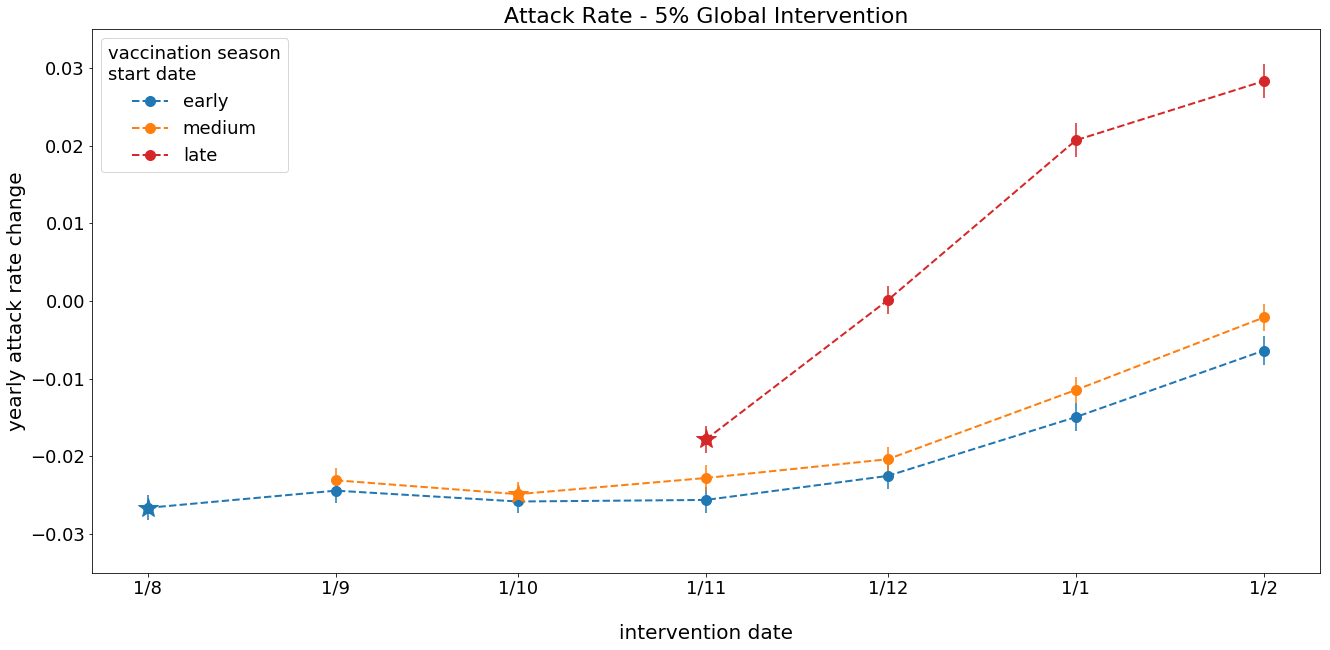

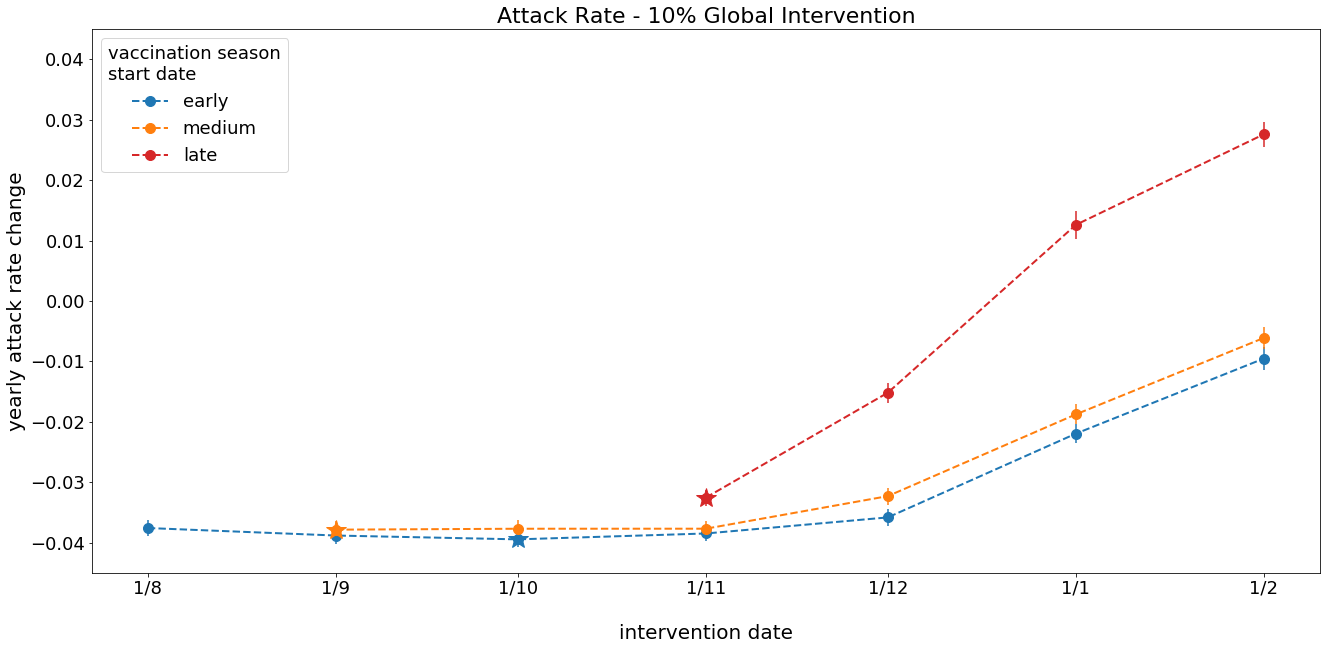

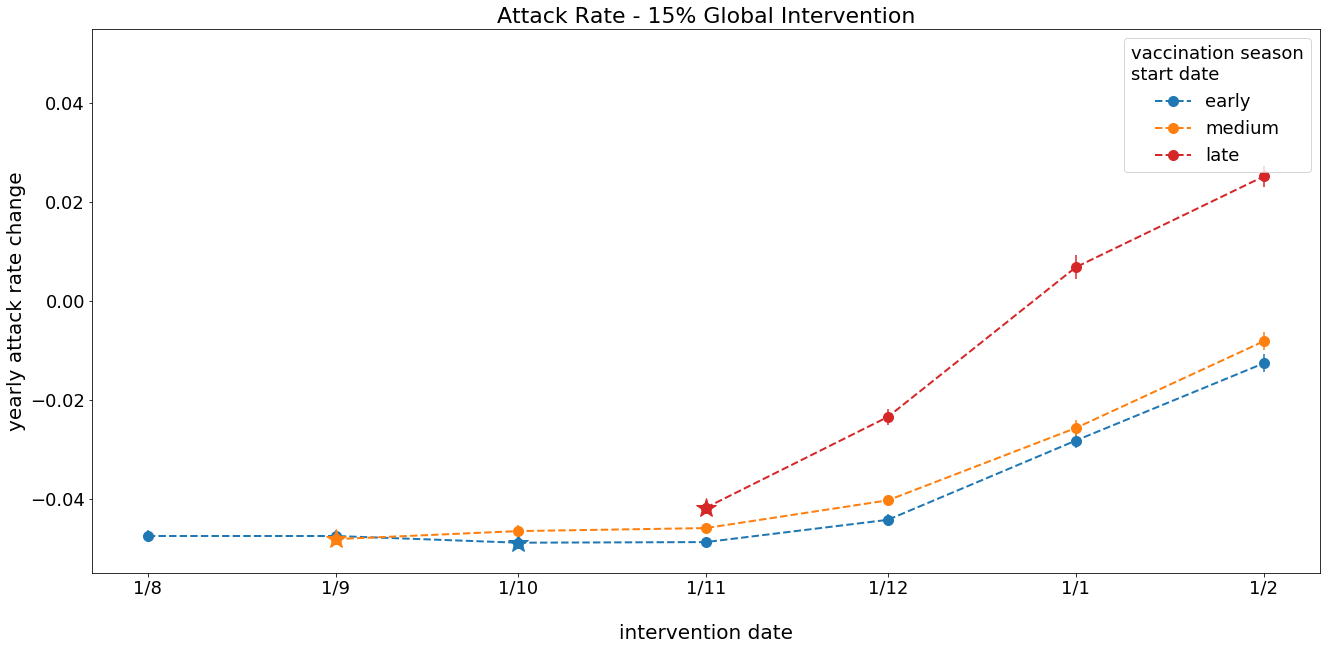

In [60]:
for j, (inter_per, intevention_res) in enumerate(inter_results_random.items()):
    
    fig = plt.figure(figsize=(22, 10))

    for i, (start_time, results) in enumerate(intevention_res.items()):
        # Remove October
        if start_time == start_times[2]:
            continue
            
        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_infection_rates = np.array([inter_res['attack_rates']['total'] for inter_res in results])
        inter_infection_rates -= baseline_attack_rates['total']
        # Get errors
        infect_rate_err = np.array([inter_res['attack_rates']['total_std'] for inter_res in results]) / np.sqrt(20*len(model.seasons))

        # Plot intervention attack rate
        plt.plot(inter_dates, inter_infection_rates, '--o', linewidth=2, label=['early', 'medium', 0, 'late'][i], #=f'{start_date.month_name()} $1^{{st}}$',
                    color=f'C{i}', markersize=10)
        
        # Mark minimum
        min_idx = np.argmin(inter_infection_rates)
        plt.plot(inter_dates[min_idx], inter_infection_rates[min_idx], '*', color=f'C{i}', markersize=20)
        
        # Plot errors
        plt.errorbar(inter_dates, inter_infection_rates, yerr=infect_rate_err, color=f'C{i}', linestyle='None')
        
        plt.ylim([[-0.035,0.035], [-0.045,0.045], [-0.055,0.055]][j])

    
    legend = plt.legend(fontsize=18, title='vaccination season\nstart date')#, loc=(1.01,0.72))
    plt.setp(legend.get_title(), fontsize=18)
    
    plt.title(f'Attack Rate - {inter_per*100:.0f}% Global Intervention', size=22)
    plt.xlabel('\nintervention date', size=20)
    plt.ylabel('yearly attack rate change', size=20)
    
    # ticks
    all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
    plt.xticks(all_dates, [f'{date.day}/{date.month}' for date in all_dates], size=18)
    plt.tick_params('y', labelsize=18)
    

    plt.show()

Plot vaccination coverage

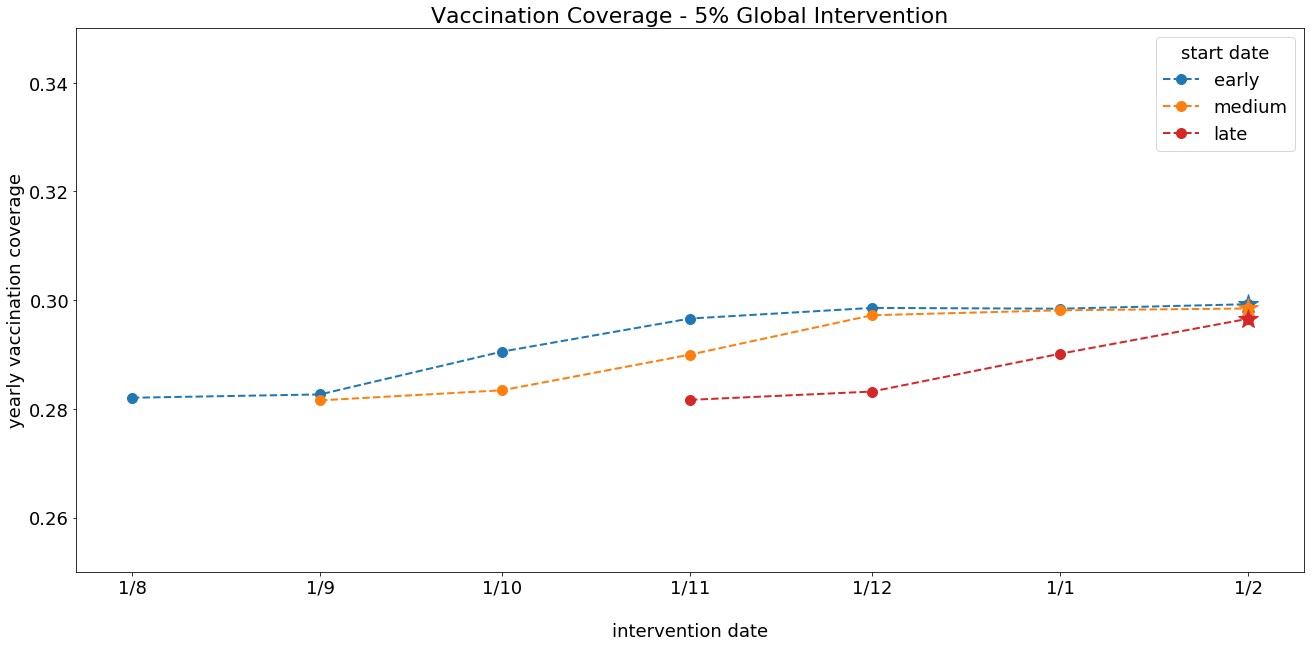

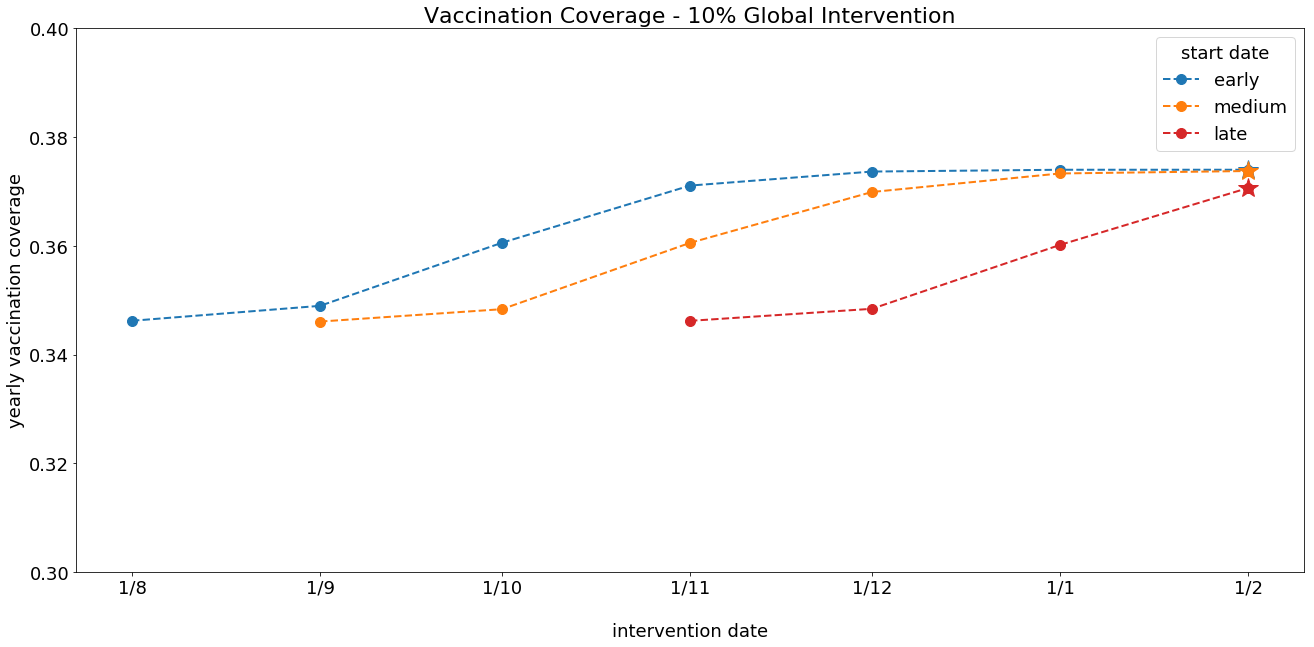

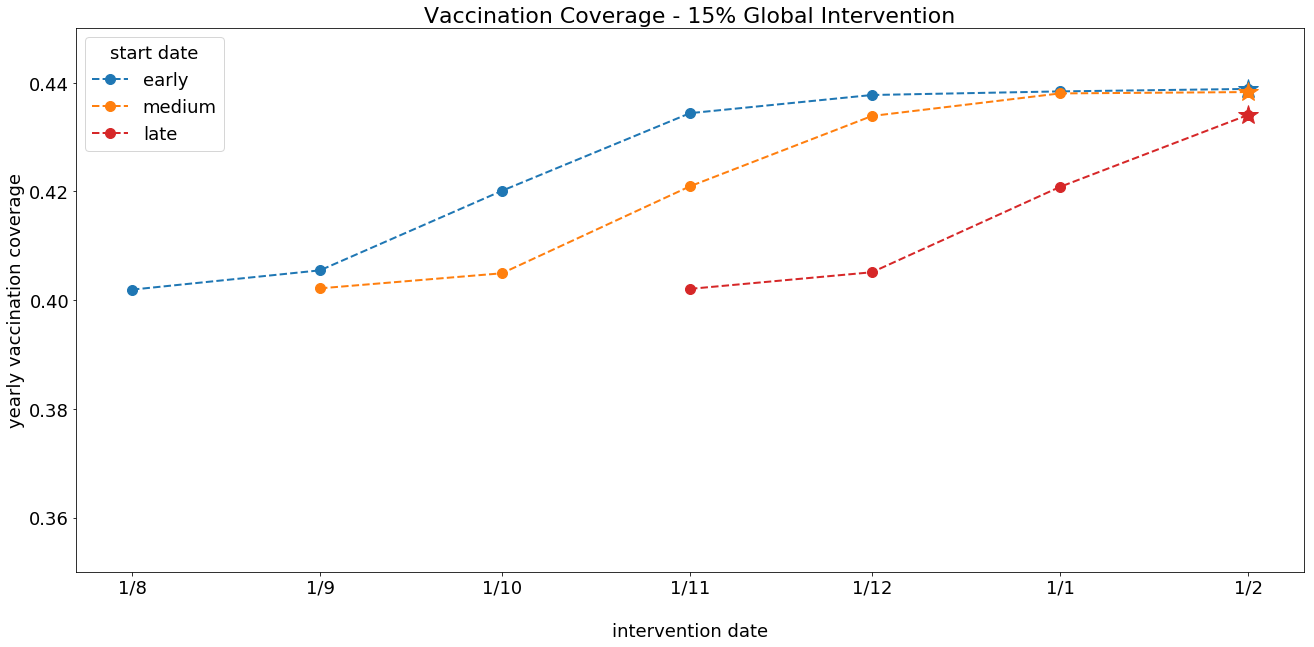

In [61]:
for j, (inter_per, intevention_res) in enumerate(inter_results_random.items()):

    fig = plt.figure(figsize=(22, 10))

    for i, (start_time, results) in enumerate(intevention_res.items()):
        # Remove October
        if start_time == start_times[2]:
            continue  

        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        
        # Get intervention results - vaccination coverage
        inter_vacc_coverage = [inter_res['vacc_coverages']['total'] for inter_res in results]
    
        # Calculate errors
        coverage_err = np.array([inter_res['vacc_coverages']['total_std'] for inter_res in results])/np.sqrt(20*len(model.seasons))


        # Plot intervention attack rate
        plt.plot(inter_dates, inter_vacc_coverage, '--o', linewidth=2, label=['early', 'medium', 0, 'late'][i],
                    color=f'C{i}', markersize=10)
        
        # Mark max
        max_idx = np.argmax(inter_vacc_coverage)
        plt.plot(inter_dates[max_idx], inter_vacc_coverage[max_idx], '*', color=f'C{i}', markersize=20)
        
        # Plot errors
        plt.errorbar(inter_dates, inter_vacc_coverage, yerr=coverage_err, color=f'C{i}', linestyle='None')
        
        plt.ylim([[0.25, 0.35], [0.3, 0.4], [0.35, 0.45]][j])

    plt.title(f'Vaccination Coverage - {inter_per*100:.0f}% Global Intervention', size=22)
    plt.xlabel('\nintervention date', size=18)
    plt.ylabel('yearly vaccination coverage', size=18)
    
    # ticks
    all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
    plt.xticks(all_dates, [f'{date.day}/{date.month}' for date in all_dates], size=18)
    plt.tick_params('y', labelsize=18)

    
    legend = plt.legend(fontsize=18, title='start date')
    plt.setp(legend.get_title(),fontsize=18)

    plt.show()

## Intervention by area

Load intervention resutls

In [62]:
with open('../../data/coupled_model/area_intervention_res_all_seasons_m20.pickle', 'rb') as pickle_in:
    intervention_restuls_list = pickle.load(pickle_in)
    
with open('../../data/coupled_model/area_intervention_res_all_seasons_m20_15per.pickle', 'rb') as pickle_in:
    intervention_restuls_list += pickle.load(pickle_in)
        
intervention_restuls_raw = {}
for d in intervention_restuls_list:
    intervention_restuls_raw.update(d)

# Save to a dict in the correct format
inter_results_area = {inter_percent: {} for inter_percent in inter_percents}
for inter_percent in inter_percents:
    for start_time in start_times:
        res = []
        for inter_time in intervention_times[start_time]:
            res.append(intervention_restuls_raw[(inter_percent, start_time, inter_time)])
        inter_results_area[inter_percent][start_time] = res

Plot attack rate

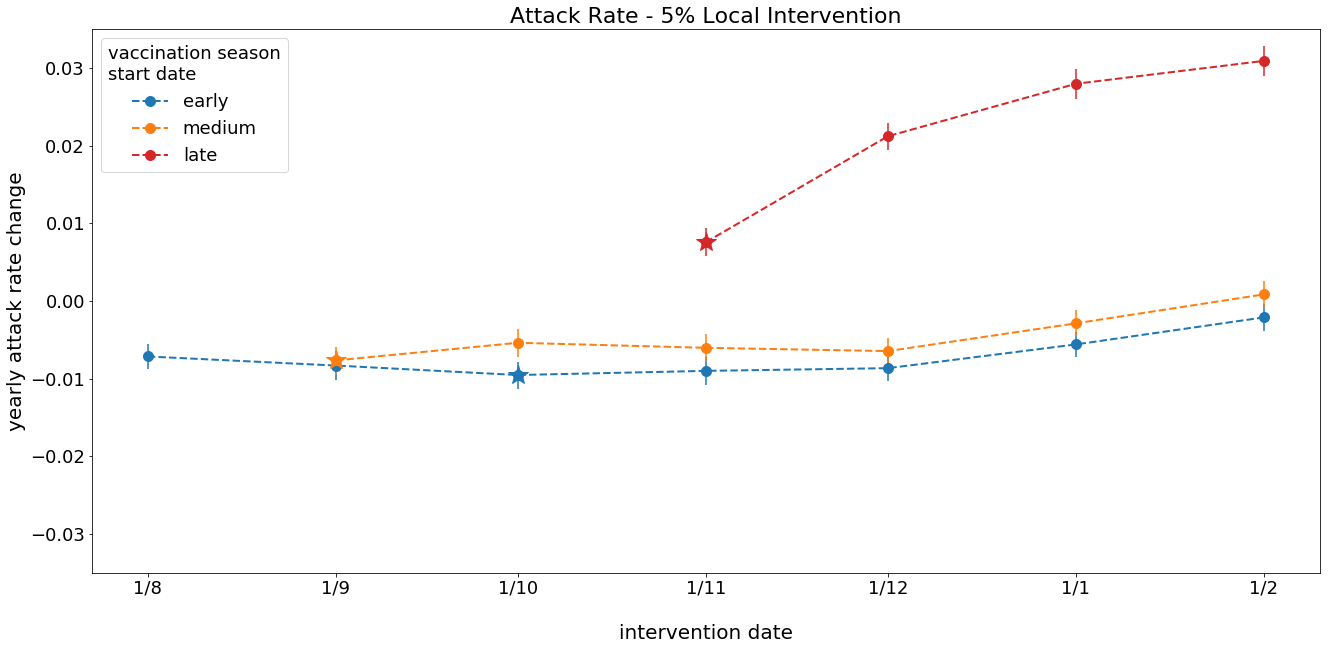

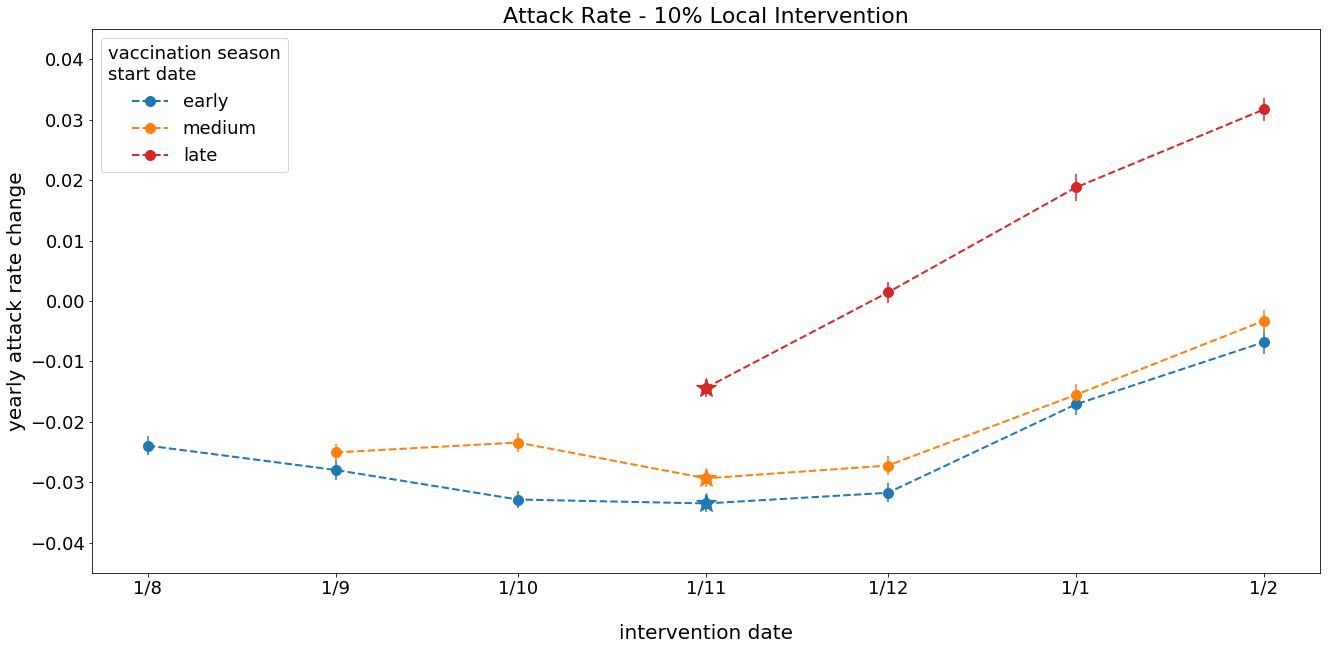

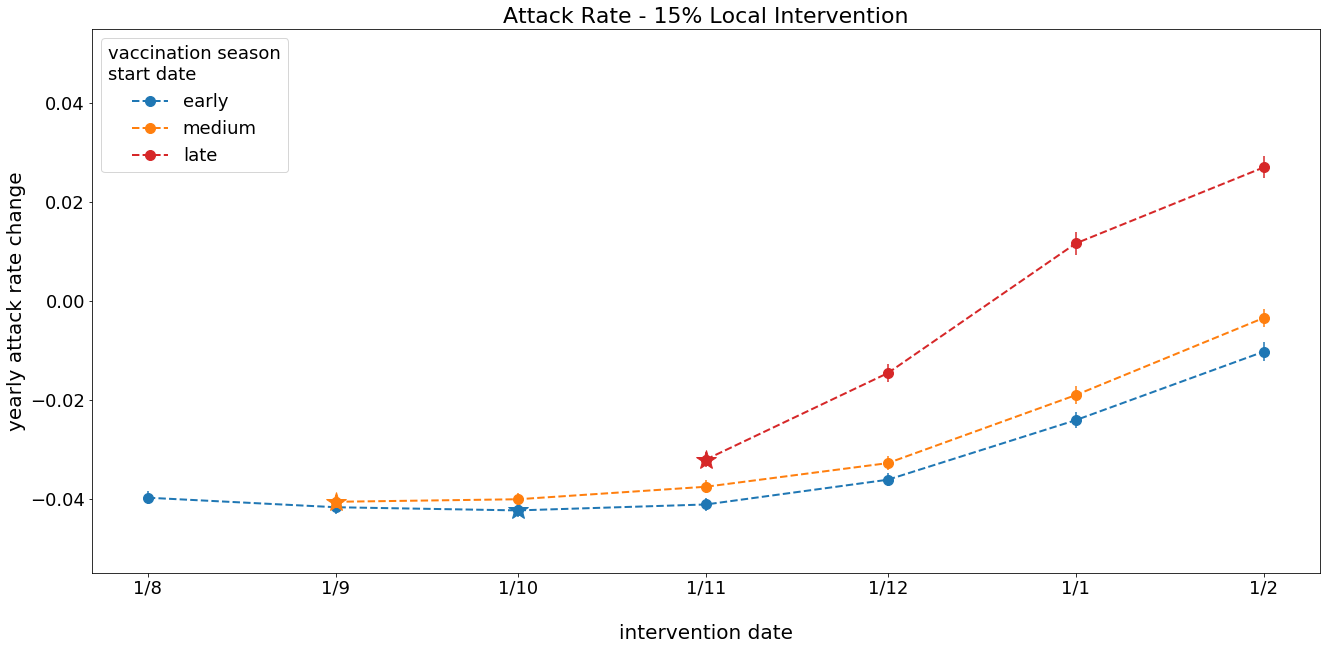

In [63]:
for j, (inter_per, intevention_res) in enumerate(inter_results_area.items()):
    
    fig = plt.figure(figsize=(22, 10))

    for i, (start_time, results) in enumerate(intevention_res.items()):
        # Remove October
        if start_time == start_times[2]:
            continue
        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_infection_rates = np.array([inter_res['attack_rates']['total'] for inter_res in results])
        inter_infection_rates -= baseline_attack_rates['total']
        # Get errors
        infect_rate_err = np.array([inter_res['attack_rates']['total_std'] for inter_res in results])/np.sqrt(20*len(model.seasons))

        # Plot intervention attack rate
        plt.plot(inter_dates, inter_infection_rates, '--o', linewidth=2, label=['early', 'medium', 0, 'late'][i], #=f'{start_date.month_name()} $1^{{st}}$',
                    color=f'C{i}', markersize=10)
        
        # Mark minimum
        min_idx = np.argmin(inter_infection_rates)
        plt.plot(inter_dates[min_idx], inter_infection_rates[min_idx], '*', color=f'C{i}', markersize=20)
        
        # Plot errors
        plt.errorbar(inter_dates, inter_infection_rates, yerr=infect_rate_err, color=f'C{i}', linestyle='None')
        
        plt.ylim([[-0.035,0.035], [-0.045,0.045], [-0.055,0.055]][j])
    
    legend = plt.legend(fontsize=18, title='vaccination season\nstart date')#, loc=(1.01,0.72))
    plt.setp(legend.get_title(), fontsize=18)
    
    plt.title(f'Attack Rate - {inter_per*100:.0f}% Local Intervention', size=22)
    plt.xlabel('\nintervention date', size=20)
    plt.ylabel('yearly attack rate change', size=20)
    
    # ticks
    all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
    plt.xticks(all_dates, [f'{date.day}/{date.month}' for date in all_dates], size=18)
    plt.tick_params('y', labelsize=18)
    


    plt.show()

Plot vaccination coverage

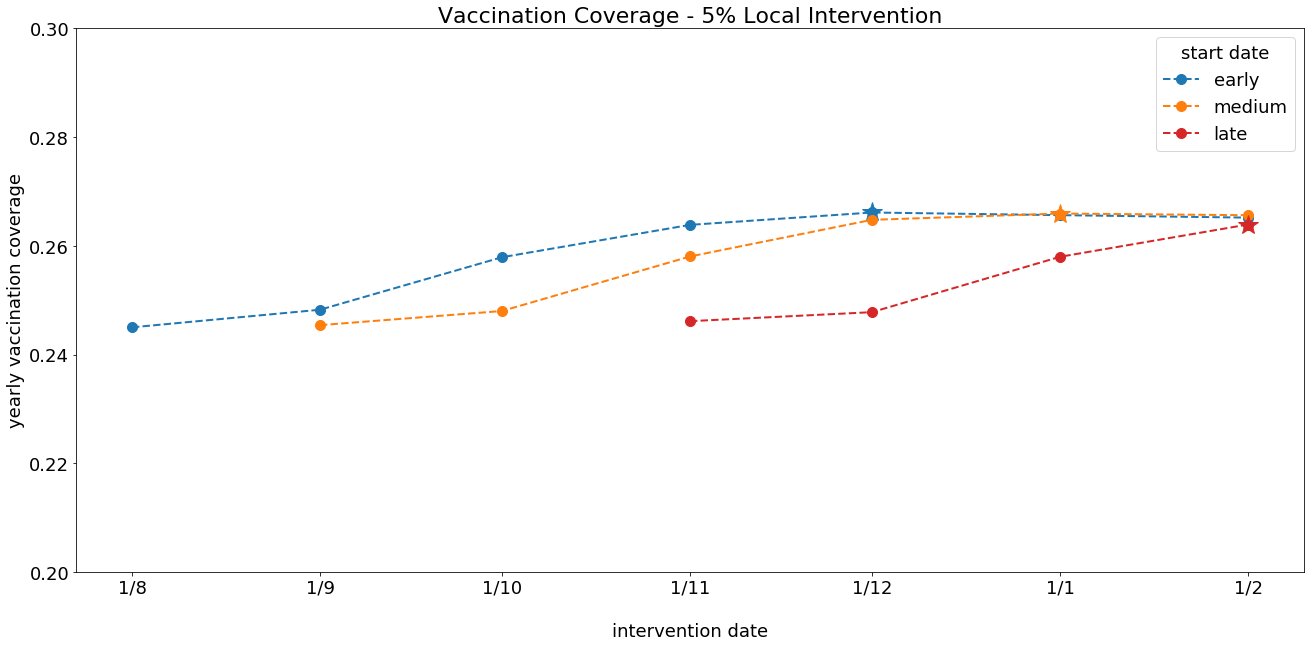

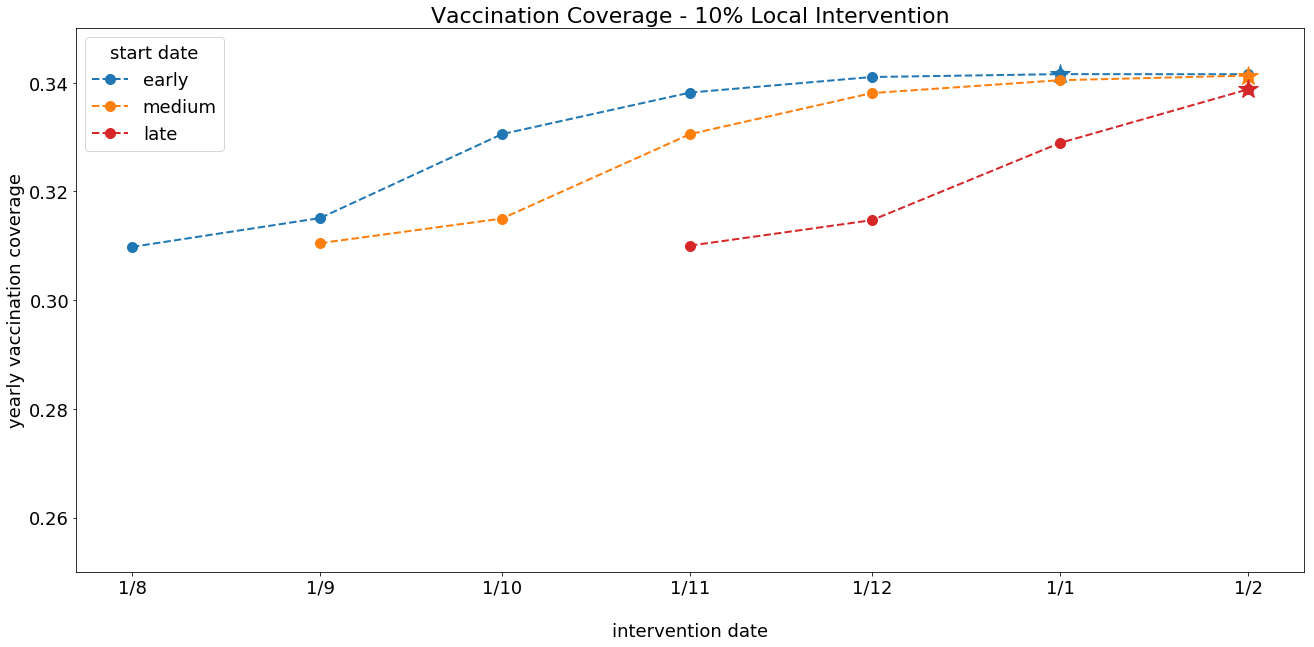

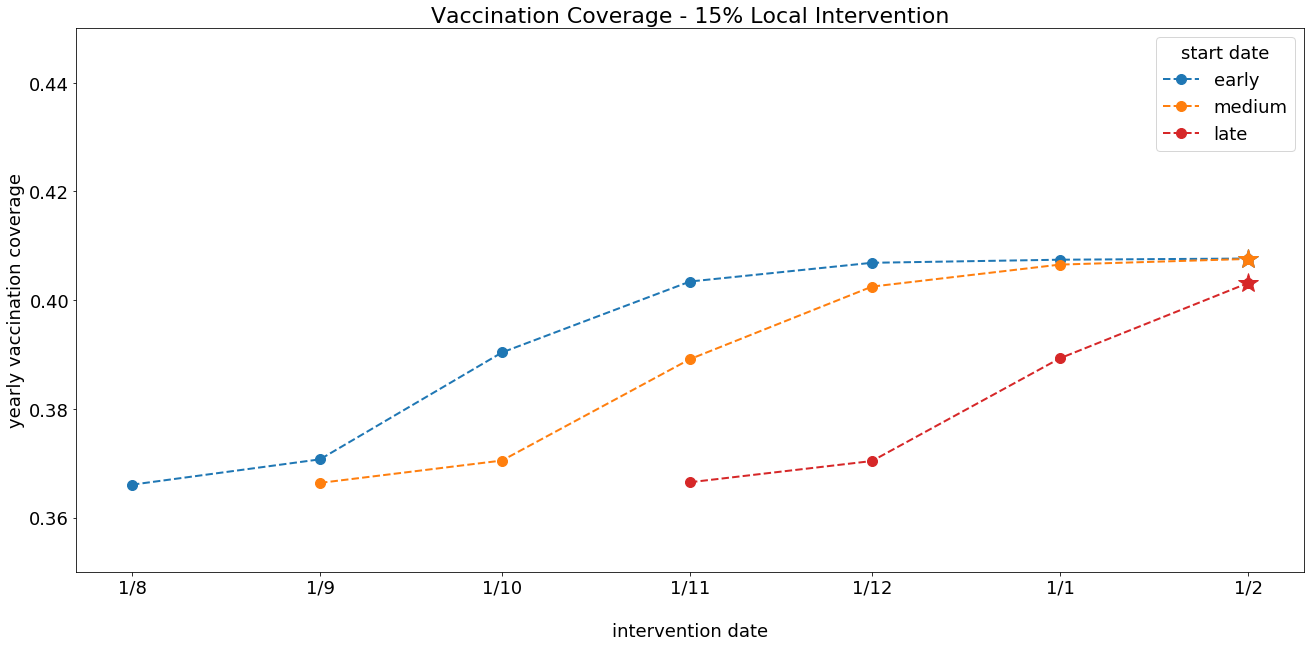

In [64]:
for j, (inter_per, intevention_res) in enumerate(inter_results_area.items()):

    fig = plt.figure(figsize=(22, 10))

    for i, (start_time, results) in enumerate(intevention_res.items()):
        # Remove October
        if start_time == start_times[2]:
            continue  

        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        
        # Get intervention results - vaccination coverage
        inter_vacc_coverage = [inter_res['vacc_coverages']['total'] for inter_res in results]
    
        # Calculate errors
        coverage_err = np.array([inter_res['vacc_coverages']['total_std'] for inter_res in results])/np.sqrt(20*len(model.seasons))

        # Plot intervention attack rate
        plt.plot(inter_dates, inter_vacc_coverage, '--o', linewidth=2, label=['early', 'medium', 0, 'late'][i],
                    color=f'C{i}', markersize=10)
        
        # Mark max
        max_idx = np.argmax(inter_vacc_coverage)
        plt.plot(inter_dates[max_idx], inter_vacc_coverage[max_idx], '*', color=f'C{i}', markersize=20)
        
        # Plot errors
        plt.errorbar(inter_dates, inter_vacc_coverage, yerr=coverage_err, color=f'C{i}', linestyle='None')
        
        plt.ylim([[0.2, 0.3], [0.25, 0.35], [0.35, 0.45]][j])

    plt.title(f'Vaccination Coverage - {inter_per*100:.0f}% Local Intervention', size=22)
    plt.xlabel('\nintervention date', size=18)
    plt.ylabel('yearly vaccination coverage', size=18)
    
    # ticks
    all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
    plt.xticks(all_dates, [f'{date.day}/{date.month}' for date in all_dates], size=18)
    plt.tick_params('y', labelsize=18)

    
    legend = plt.legend(fontsize=18, title='start date')
    plt.setp(legend.get_title(),fontsize=18)

    plt.show()

[0.05, 0.1]

In [52]:
with open('../../data/coupled_model/subdist_intervention_res_all_seasons_m5.pickle', 'rb') as pickle_in:
    intervention_restuls_list = pickle.load(pickle_in)
        
intervention_restuls_raw = {}
for d in intervention_restuls_list:
    intervention_restuls_raw.update(d)

# Save to a dict in the correct format
inter_results_subdist = {inter_percent: {} for inter_percent in inter_percents[:2]}
for inter_percent in inter_percents[:2]:
    for start_time in start_times:
        res = []
        for inter_time in intervention_times[start_time]:
            res.append(intervention_restuls_raw[(inter_percent, start_time, inter_time)])
        inter_results_subdist[inter_percent][start_time] = res

In [56]:
inter_results_subdist[0.1][61][2]

{'attack_rates': {'total': 0.03786998873270441,
  'total_std': 0.016268415908494396,
  'children': 0.06289532206325155,
  'children_std': 0.02662167946447593,
  'adult_rate': 0.027430722310474054,
  'adult_std': 0.012029609647455435},
 'vacc_coverages': {'total': 0.36155332269360774,
  'total_std': 0.004808479484623762,
  'children': 0.2500383760061402,
  'children_std': 0.004053356197400672,
  'adult_rate': 0.4080715537658905,
  'adult_std': 0.005378739520973122},
 'effctive_vacc_coverages': {'total': 0.11721347325248299,
  'total_std': 0.002034482939890681}}

Plot attack rate

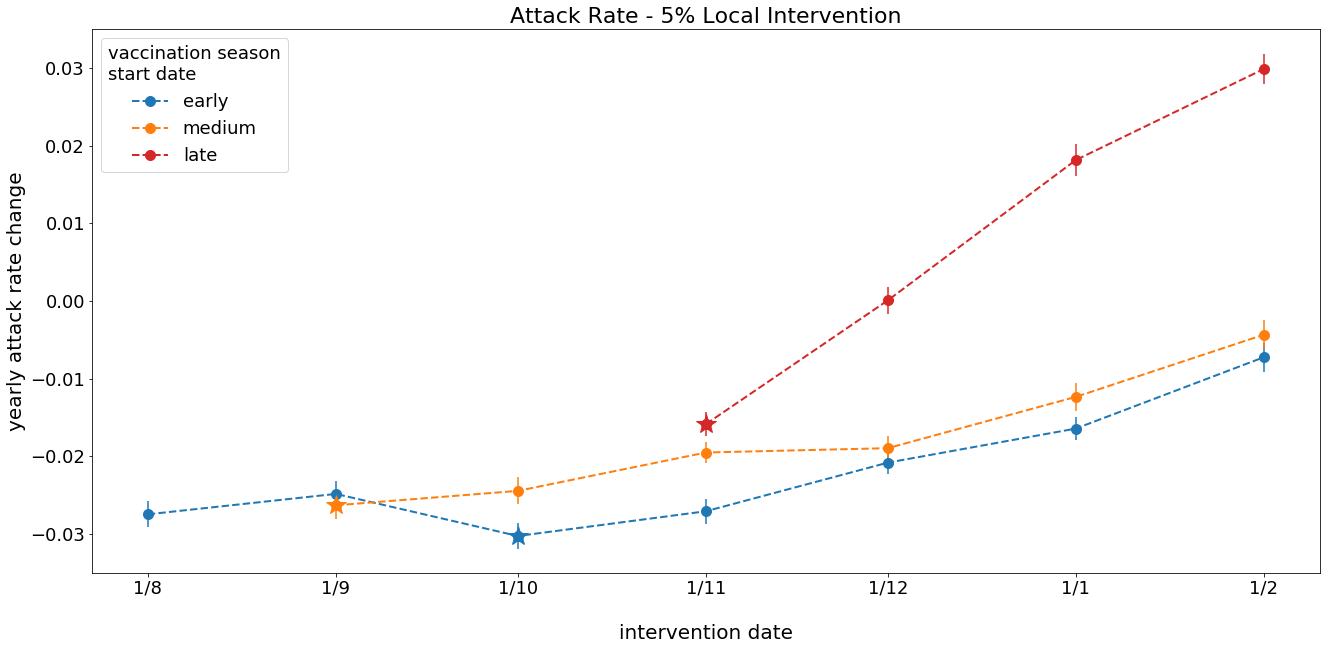

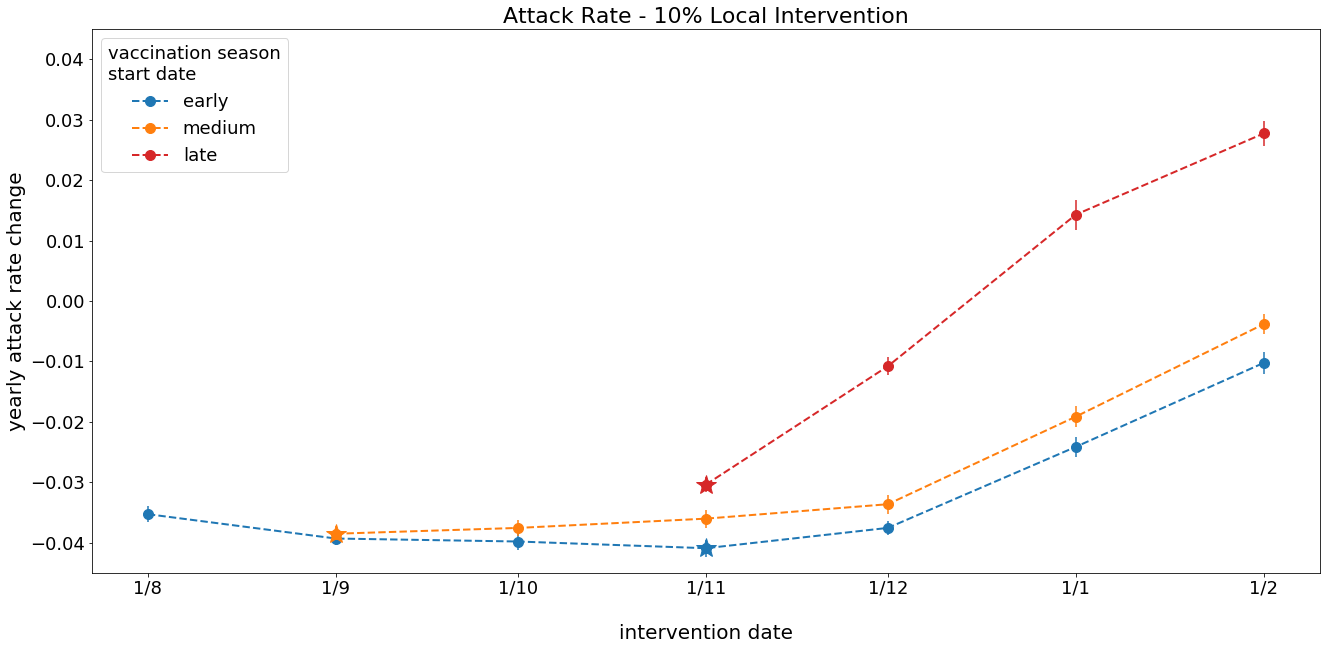

In [53]:
for j, (inter_per, intevention_res) in enumerate(inter_results_subdist.items()):
    
    fig = plt.figure(figsize=(22, 10))

    for i, (start_time, results) in enumerate(intevention_res.items()):
        # Remove October
        if start_time == start_times[2]:
            continue
        # Get intervention dates
        inter_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_infection_rates = np.array([inter_res['attack_rates']['total'] for inter_res in results])
        inter_infection_rates -= baseline_attack_rates['total']
        # Get errors
        infect_rate_err = np.array([inter_res['attack_rates']['total_std'] for inter_res in results])/np.sqrt(20*len(model.seasons))

        # Plot intervention attack rate
        plt.plot(inter_dates, inter_infection_rates, '--o', linewidth=2, label=['early', 'medium', 0, 'late'][i], #=f'{start_date.month_name()} $1^{{st}}$',
                    color=f'C{i}', markersize=10)
        
        # Mark minimum
        min_idx = np.argmin(inter_infection_rates)
        plt.plot(inter_dates[min_idx], inter_infection_rates[min_idx], '*', color=f'C{i}', markersize=20)
        
        # Plot errors
        plt.errorbar(inter_dates, inter_infection_rates, yerr=infect_rate_err, color=f'C{i}', linestyle='None')
        
        plt.ylim([[-0.035,0.035], [-0.045,0.045], [-0.055,0.055]][j])
    
    legend = plt.legend(fontsize=18, title='vaccination season\nstart date')#, loc=(1.01,0.72))
    plt.setp(legend.get_title(), fontsize=18)
    
    plt.title(f'Attack Rate - {inter_per*100:.0f}% Local Intervention', size=22)
    plt.xlabel('\nintervention date', size=20)
    plt.ylabel('yearly attack rate change', size=20)
    
    # ticks
    all_dates = [pd.Timestamp(2016 - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
    plt.xticks(all_dates, [f'{date.day}/{date.month}' for date in all_dates], size=18)
    plt.tick_params('y', labelsize=18)
    


    plt.show()

### By score

In [274]:
# Load nodes by area and age
with open(model.nodes_by_area_age_dict_path, 'rb') as pickle_in:
    nodes_by_area_age = pickle.load(pickle_in)

# Calculate population proportion by area
area_prop_pop = {}
for area, age in nodes_by_area_age:
    area_prop_pop[(area, age)] = len(nodes_by_area_age[(area, age)]) / prep_data['N']

nodes_by_area_age.pop((3000211, 1))
nodes_by_area_age.pop((3000211, 0))

# Load page ranks
with open(model.pagerank_by_area_age_path, 'rb') as pickle_in:
    pageranks = pickle.load(pickle_in)

# Calculate area scores
area_scores = {(area, age): area_prop_pop[(area, age)]*pageranks[(area, age)] for area, age in nodes_by_area_age}

# Normalize scores to a sum of 1
area_scores_norm = {(area, age): score/sum(list(area_scores.values()))
                    for (area, age), score in area_scores.items()}

# Sort areas and age groups by page rank (descending)
areas_age_by_rank_with_rank = sorted(list(pageranks.items()), key=lambda x: x[1], reverse=True)
areas_age_by_rank = list(map(lambda x: x[0], areas_age_by_rank_with_rank))
  
# # Fliter irrelevant areas
# areas_age_by_rank = list(filter(lambda x: x in nodes_by_area_age, areas_age_by_rank))
# areas_age_by_rank_with_rank = list(filter(lambda x: x[0] in nodes_by_area_age, areas_age_by_rank_with_rank))

# # Create a list of nodes by PageRank
# nodes_by_rank = []
# for (area, age) in areas_age_by_rank:
#     nodes_by_rank += list(nodes_by_area_age[(area, age)])

In [275]:
areas_age_by_rank_with_rank

[((6271, 0), 0.01069079136852061),
 ((3000211, 1), 0.007944274199129249),
 ((5141, 1), 0.00683990450220609),
 ((25504, 0), 0.005825863123721719),
 ((6271, 1), 0.00545871755832008),
 ((36501, 0), 0.005079241121195469),
 ((25504, 1), 0.0037975208980453377),
 ((36501, 1), 0.003610453779350496),
 ((10312, 1), 0.0034296457744605615),
 ((8400116, 1), 0.0034256259257234253),
 ((6331, 0), 0.0032154526491124454),
 ((10314, 1), 0.0030073582904763542),
 ((870031, 1), 0.00298174566268046),
 ((7100314, 1), 0.002981347107148302),
 ((970023, 1), 0.0028998534297685094),
 ((265013, 1), 0.002808421344991402),
 ((10661, 1), 0.002764416436852058),
 ((281, 1), 0.002578096351899665),
 ((5000929, 1), 0.002526344660776994),
 ((5000315, 1), 0.002489164308630817),
 ((6200111, 1), 0.00247246128410697),
 ((281, 0), 0.0024065016525281666),
 ((4661, 1), 0.0023607785821201004),
 ((4721, 0), 0.002340595428064143),
 ((8300533, 0), 0.002338168140627657),
 ((7900312, 1), 0.00233118333856035),
 ((970021, 1), 0.0023151998

In [272]:
areas = [x[0] for x in areas_age_by_rank_with_rank]
scores = [x[1] for x in areas_age_by_rank_with_rank]

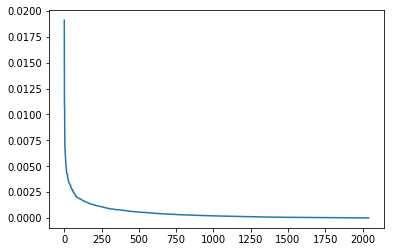

In [267]:
plt.plot(scores)

In [273]:
list(np.random.multinomial(1000, scores))

[9,
 11,
 8,
 12,
 8,
 10,
 2,
 2,
 2,
 4,
 6,
 5,
 4,
 3,
 2,
 2,
 4,
 4,
 0,
 4,
 2,
 3,
 3,
 4,
 4,
 2,
 1,
 1,
 0,
 1,
 3,
 2,
 2,
 2,
 0,
 2,
 1,
 3,
 2,
 2,
 1,
 3,
 0,
 1,
 4,
 4,
 2,
 2,
 0,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 3,
 1,
 2,
 2,
 4,
 2,
 0,
 2,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 3,
 4,
 1,
 1,
 1,
 1,
 3,
 2,
 0,
 2,
 0,
 1,
 2,
 1,
 4,
 1,
 1,
 3,
 1,
 4,
 1,
 0,
 1,
 4,
 2,
 3,
 1,
 3,
 2,
 3,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 3,
 0,
 1,
 0,
 2,
 3,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 3,
 0,
 2,
 0,
 0,
 0,
 1,
 5,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 0,
 1,
 2,
 1,
 1,
 2,
 3,
 3,
 1,
 5,
 1,
 0,
 0,
 0,
 1,
 2,
 3,
 1,
 2,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 4,
 1,
 1,
 1,
 0,
 1,
 2,
 0,
 0,
 4,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 2,
 0,
 0,
 3,
 2,
 1,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 

Load intervention resutls

In [20]:
# [start_date + pd.Timedelta(days=1) * i for i in range(62)]
# pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=245)

In [230]:
# [pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=x) for x in [61, 92, 122, 153, 183, 214, 245]]

Create intervention dictionary - intervention for each combintion of:
* intervention rate 
* start time
* each intervention time

In [59]:
iner = interventions_dict[0.1][61][0]

In [64]:
# Set intervention parameters
# Intervention percents
inter_percents = [0.05, 0.1]

# Vaccination season start time:  1.8, 1.9, 1.10, 1.11
start_times = [61, 92, 122, 153]

# Intervention times (by start time)
all_inter_times = [61, 92, 122, 153, 183, 214, 245]  # 1.8, 1.9, 1.10, 1.11, 1.12, 1.1, 1.2
intervention_times = {61: all_inter_times, 92: all_inter_times[1:], 122: all_inter_times[2:], 153: all_inter_times[3:]}

# Random intervention dict
interventions_dict = {inter_percent:
                      {start_time: [{'time': time, 'percent': inter_percent, 'len': length, 'vacc_start': start_time, 'type': 'random'}
                                    for time in intervention_times[start_time]]
                       for start_time in start_times}
                      for inter_percent in inter_percents}
# Unpack dictionary
interventions_list = []
for inter_percent in interventions_dict:
    for start_time, inter in interventions_dict[inter_percent].items():
        interventions_list.extend(inter)

In [55]:
interventions_dict = {inter_percent:
                      {start_time: [{'time': time, 'percent': inter_percent, 'len': length, 'vacc_start':start_time, 'type': 'random'} 
                                   for time in intervention_times[start_time]]
                       for start_time in start_times}
                      for inter_percent in inter_percents}

# interventions_dict = {inter_percent:
#                       {start_time: [{'time': time, 'percent': inter_percent, 'len': length, 'vacc_start':start_time} 
#                                    for time in np.arange(start_time, 230+inter_time_jumps, inter_time_jumps)]
#                        for start_time in start_times}
#                       for inter_percent in inter_percents}

In [15]:
# inter_results = {inter_percent: 
#                  {start_time: [intervention_coupled_model(parameters_i, parameters_v, prep_data, data_for_fit_i, data_for_fit_v,
#                                                           season, intervention, start_time, num_of_simulations=m)
#                                for intervention in tqdm_notebook(interventions)]
#                   for start_time, interventions in inters_dict.items()}
#                  for inter_percent, inters_dict in interventions_dict.items()}

In [ ]:
# with open('../../data/coupled_model/inter_res.pickle', 'wb') as pickle_out:
#     pickle.dump(inter_results, pickle_out)

In [13]:
# Load page ranks
with open('../../Data/vaccination_data/pagerank_by_subdist_age.pickle', 'rb') as pickle_in:
    pageranks_subdist = pickle.load(pickle_in)

# Sort areas and age groups by page rank (descending)
subdists_age_by_rank_with_rank = sorted(list(pageranks_subdist.items()), key=lambda x: x[1], reverse=True)
subdists_age_by_rank = list(map(lambda x: x[0], subdists_age_by_rank_with_rank))

In [15]:
subdists_age_by_rank_with_rank

[((51.0, 1), 0.3332721659303089),
 ((51.0, 0), 0.12549684818350632),
 ((11.0, 1), 0.11550368607245155),
 ((42.0, 1), 0.11296923291112959),
 ((11.0, 0), 0.07477191982413495),
 ((42.0, 0), 0.0628346968565337),
 ((61.0, 1), 0.045217579107343864),
 ((43.0, 1), 0.029693560336998027),
 ((61.0, 0), 0.0256622429061379),
 ((43.0, 0), 0.02329733884412221),
 ((44.0, 1), 0.02327904513627593),
 ((44.0, 0), 0.010869955850665738),
 ((77.0, 0), 0.008781277637100597),
 ((77.0, 1), 0.008350450403290783)]

In [286]:
np.random.multinomial(1000, [x[1] for x in areas_age_by_rank_with_rank])

array([333, 132, 119, 109,  90,  62,  37,  23,  23,  27,  22,   8,   9,
         6])

In [ ]:
# Load nodes by area and age
with open(model.nodes_by_area_age_dict_path, 'rb') as pickle_in:
    nodes_by_area_age = pickle.load(pickle_in)
    
# Load nodes by area and age
with open(model.nodes_by_area_age_dict_path, 'rb') as pickle_in:
    nodes_by_area_age = pickle.load(pickle_in)

In [276]:
# Load page ranks
with open(model.pagerank_by_area_age_path, 'rb') as pickle_in:
# with open('../../Data/vaccination_data/pagerank_by_area_age_thresh.pickle', 'rb') as pickle_in:
# with open('../../Data/vaccination_data/pagerank_by_area_age_net.pickle', 'rb') as pickle_in:
    pageranks = pickle.load(pickle_in)
    
# Sort areas and age groups by page rank (descending)
areas_age_by_rank_with_rank = sorted(list(pageranks.items()), key=lambda x: x[1], reverse=True)
areas_age_by_rank = list(map(lambda x: x[0], areas_age_by_rank_with_rank))
  
# Fliter irrelevant areas
areas_age_by_rank = list(filter(lambda x: x in nodes_by_area_age, areas_age_by_rank))
areas_age_by_rank_with_rank = list(filter(lambda x: x[0] in nodes_by_area_age, areas_age_by_rank_with_rank))

# Create a list of nodes by PageRank
nodes_by_rank = []
for (area, age) in areas_age_by_rank:
    nodes_by_rank += list(nodes_by_area_age[(area, age)])

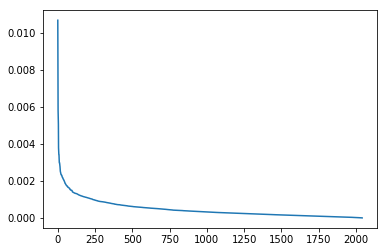

In [279]:
plt.plot([x[1] for x in areas_age_by_rank_with_rank])

Create intervention dict

In [ ]:
interventions_dict_area = {inter_percent:
                           {start_time: [{'time': time, 'percent': inter_percent, 'len': length, 'vacc_start':start_time,
                                          'type': 'by_area', 'nodes_by_rank': nodes_by_rank}
                                         for time in intervention_times[start_time]]
                            for start_time in start_times}
                           for inter_percent in inter_percents}

In [ ]:
inter_results_by_area = {inter_percent:
                         {start_time: [intervention_coupled_model(parameters_i, parameters_v, prep_data, data_for_fit_i,
                                                                  data_for_fit_v, season, intervention, start_time,
                                                                  num_of_simulations=m)
                                       for intervention in tqdm_notebook(interventions)]
                          for start_time, interventions in inters_dict.items()}
                         for inter_percent, inters_dict in interventions_dict_area.items()}

In [ ]:
with open('../../data/coupled_model/inter_res_by_area.pickle', 'wb') as pickle_out:
    pickle.dump(inter_results_by_area, pickle_out)

# OLD

In [11]:
def intervention_coupled_model(parameters_i, parameters_v, prep_data, data_for_fit_i, data_for_fit_v,
                                season, intervention, vacc_start, num_of_simulations):  
    # Initialize lists for infection rate and vaccination coverage
    infection_rate_list = []
    vacc_coverage_list = []
    effective_vacc_coverage_list = []
    
    for season in model.seasons:
        for i in range(num_of_simulations):
            # Run the model
            model_res = model.run_coupled_model(parameters_i, parameters_v, prep_data, season, intervention=intervention
                                               ,vacc_start=vacc_start)

            # Calculate infection rate and add to the list
            infection_rate = model.get_infection_rate_by_age(model_res, data_for_fit_i, prep_data, season).model
            infection_rate_list.append(infection_rate)

            # Calculate vaccination coverage and add to the list
            model_res['new_I_by_age'] = model_res['new_Iv_by_age']
            model_res['I'] = model_res['Iv']
            vacc_coverage = model.get_vaccination_coverage_by_age(model_res, data_for_fit_v, prep_data).model
            vacc_coverage_list.append(vacc_coverage)

            # Calculate effective vaccination coverage and add to the list
            Vs = set()
            for v in model_res['Vi']:
                Vs = Vs.union(v)
            effective_vacc_coverage =  len(Vs) / prep_data['N']
            effective_vacc_coverage_list.append(effective_vacc_coverage)
        
    # Create arrays
    total_attack_rates = np.array([r['total'] for r in infection_rate_list])
    children_attack_rates = np.array([r['children'] for r in infection_rate_list])
    adult_attack_rates = np.array([r['adults'] for r in infection_rate_list])

    total_vacc_coverage = np.array([c['total'] for c in vacc_coverage_list])
    children_vacc_coverage = np.array([c['children'] for c in vacc_coverage_list])
    adult_vacc_coverage = np.array([c['adults'] for c in vacc_coverage_list])

    eff_vacc_coverage = np.array(effective_vacc_coverage_list)

    # Calculate mean and std/n
    attack_rates = {'total': total_attack_rates.mean(), 'total_std': total_attack_rates.std()/total_attack_rates.size,
                    'children': children_attack_rates.mean(), 'children_std': children_attack_rates.std()/children_attack_rates.size,
                    'adult_rate': adult_attack_rates.mean(), 'adult_std': adult_attack_rates.std()/adult_attack_rates.size}

    vacc_coverages = {'total': total_vacc_coverage.mean(), 'total_std': total_vacc_coverage.std()/total_vacc_coverage.size,
                    'children': children_vacc_coverage.mean(), 'children_std': children_vacc_coverage.std()/children_vacc_coverage.size,
                    'adult_rate': adult_vacc_coverage.mean(), 'adult_std': adult_vacc_coverage.std()/adult_vacc_coverage.size}

    effctive_vacc_coverages = {'total': eff_vacc_coverage.mean(), 'total_std': eff_vacc_coverage.std()/eff_vacc_coverage.size}
    
    return {'attack_rates': attack_rates, 'vacc_coverages': vacc_coverages, 'effctive_vacc_coverages': effctive_vacc_coverages}
    
#     # Get median realization (by total infection rate)
#     total_infection_rates = list(map(lambda x: x['total'], infection_rate_list))
#     med = np.argsort(np.array(total_infection_rates))[len(total_infection_rates) // 2]
    
#     # Return median realization's infection rate and effctive vaccination coverage
#     return infection_rate_list[med], vacc_coverage_list[med], effective_vacc_coverage_list[med]#, model_res

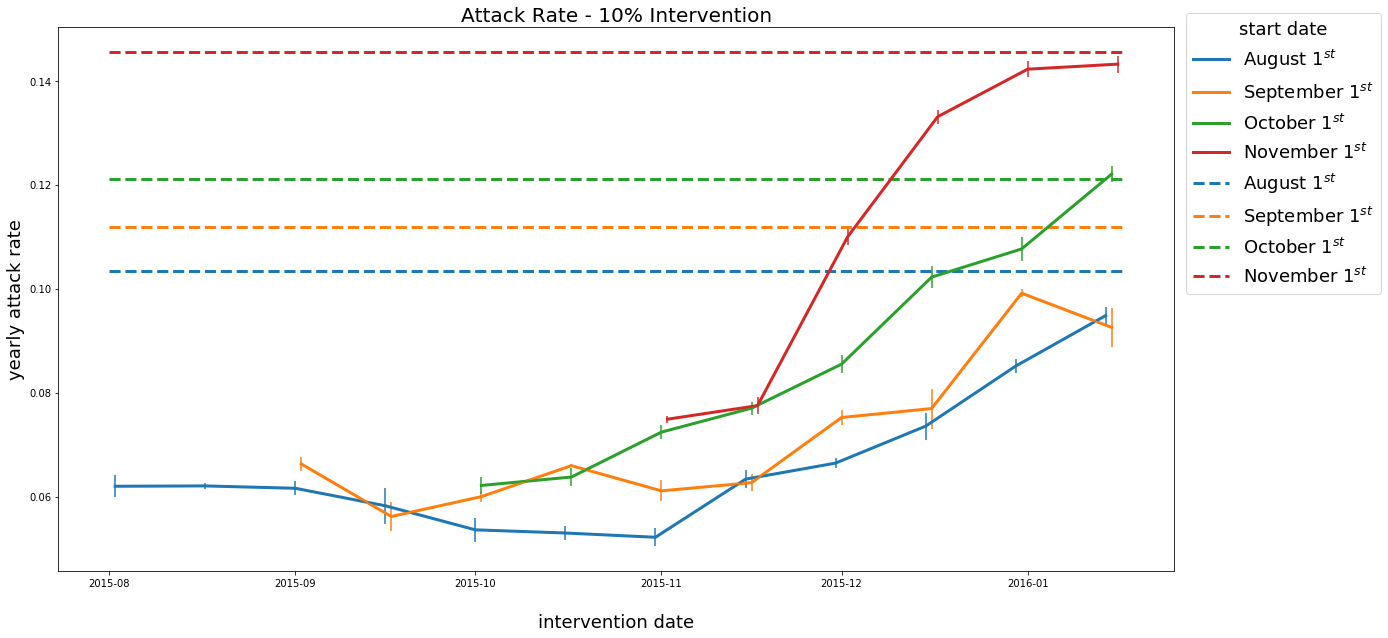

In [93]:
fig = plt.figure(figsize=(20, 10))

for i, (start_time, results) in enumerate(inter_results.items()):
    # Get start date
    start_date = pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=start_time - 1)
    # Get intervention dates
    inter_dates = [pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=day)
                   for day in np.arange(start_time, 230+inter_time_jumps, inter_time_jumps)]
    # Get intervention results
    inter_infection_rates = [inter_res['attack_rates']['total'] for inter_res in results]
#     inter_vacc_coverage = [inter_res['vacc_coverages']['total'] for inter_res in results]
#     inter_eff_vacc_coverage = [inter_res['effctive_vacc_coverages']['total'] for inter_res in results]
    
    # Calculate errors
    infect_rate_err = [inter_res['attack_rates']['total_std'] for inter_res in results]

    # Plot intervention attack rate
    plt.plot(inter_dates, inter_infection_rates, linewidth=3, label=f'{start_date.month_name()} $1^{{st}}$', color=f'C{i}')
    # Plot errors
    plt.errorbar(inter_dates, inter_infection_rates,yerr=infect_rate_err, color=f'C{i}')

# No intervention
no_inter_lines = [0]*len(no_inter_res)
for i, (start_time, res) in enumerate(no_inter_res.items()):
    # Get start date
    start_date = pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=start_time - 1)
    no_inter_attack_rate = res['attack_rates']['total']
    no_inter_lines[i] = plt.hlines(no_inter_attack_rate, pd.Timestamp(season - 1, 8, 1), pd.Timestamp(season, 1, 17),
               linestyle='--', linewidth=3, color=f'C{i}', label=f'{start_date.month_name()} $1^{{st}}$')
    
plt.title('Attack Rate - 10% Intervention', size=20)
plt.xlabel('\nintervention date', size=18)
plt.ylabel('yearly attack rate', size=18)

legend = plt.legend(fontsize=18, title='start date', loc=(1.01,0.51))
legend2 = plt.legend(no_inter_lines, fontsize=18, title='start date', loc=(1.01,0.51))
plt.gca().add_artist(legend2)


plt.setp(legend.get_title(), fontsize=18)

plt.show()

In [ ]:
for inter_per, intevention_res in inter_results.items():
    fig = plt.figure(figsize=(22, 10))

    for i, (start_time, results) in enumerate(intevention_res.items()):
        # Remove October
        if start_time == start_times[2]:
            continue
        
        # Get start date
        start_date = pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=start_time)
        # Get intervention dates
        inter_dates = [pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_time]]
        # Get intervention results
        inter_infection_rates = [inter_res['attack_rates']['total'] for inter_res in results]
        # Get errors
        infect_rate_err = [inter_res['attack_rates']['total_std'] for inter_res in results]

        # Plot intervention attack rate
        plt.plot(inter_dates, inter_infection_rates, '--o', linewidth=2, label=['early', 'medium', 0, 'late'][i], #=f'{start_date.month_name()} $1^{{st}}$',
                    color=f'C{i}', markersize=10)
        
        # Mark minimum
        min_idx = np.argmin(inter_infection_rates)
        plt.plot(inter_dates[min_idx], inter_infection_rates[min_idx], '*', color=f'C{i}', markersize=20)
        
        # Plot errors
#         plt.errorbar(inter_dates, inter_infection_rates, yerr=infect_rate_err, color=f'C{i}')
    
    legend = plt.legend(fontsize=18, title='vaccination season\nstart date', loc=(1.01,0.72))

#     # No intervention
#     no_inter_lines = []
#     no_inter_lines_labels = []
#     for i, (start_time, res) in enumerate(no_inter_res.items()):
#         # Get start date
#         start_date = pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=start_time - 1)
#         no_inter_attack_rate = res['attack_rates']['total']
#         no_inter_lines.append(plt.hlines(no_inter_attack_rate, pd.Timestamp(season - 1, 8, 1), pd.Timestamp(season, 1, 31),
#                    linestyle='--', linewidth=3, color=f'C{i}', label=f'{start_date.month_name()} $1^{{st}}$'))
#         no_inter_lines_labels.append(f'{start_date.month_name()} $1^{{st}}$')

    plt.title(f'Attack Rate - {inter_per*100:.0f}% Intervention', size=22)
    plt.xlabel('\nintervention date', size=20)
    plt.ylabel('yearly attack rate', size=20)
    # xticks
#     all_dates = [pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=day) for day in np.arange(start_times[0], 230+inter_time_jumps, inter_time_jumps)]
    all_dates = [pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=x) for x in intervention_times[start_times[0]]]
    plt.xticks(all_dates, [f'{date.day}/{date.month}' for date in all_dates], size=18)


#     legend2 = plt.legend(no_inter_lines, no_inter_lines_labels, fontsize=18, title='no intervention', loc=(1.01,0.4))
#     plt.gca().add_artist(legend)


    plt.setp(legend.get_title(), fontsize=18)
#     plt.setp(legend2.get_title(), fontsize=18)


    plt.show()

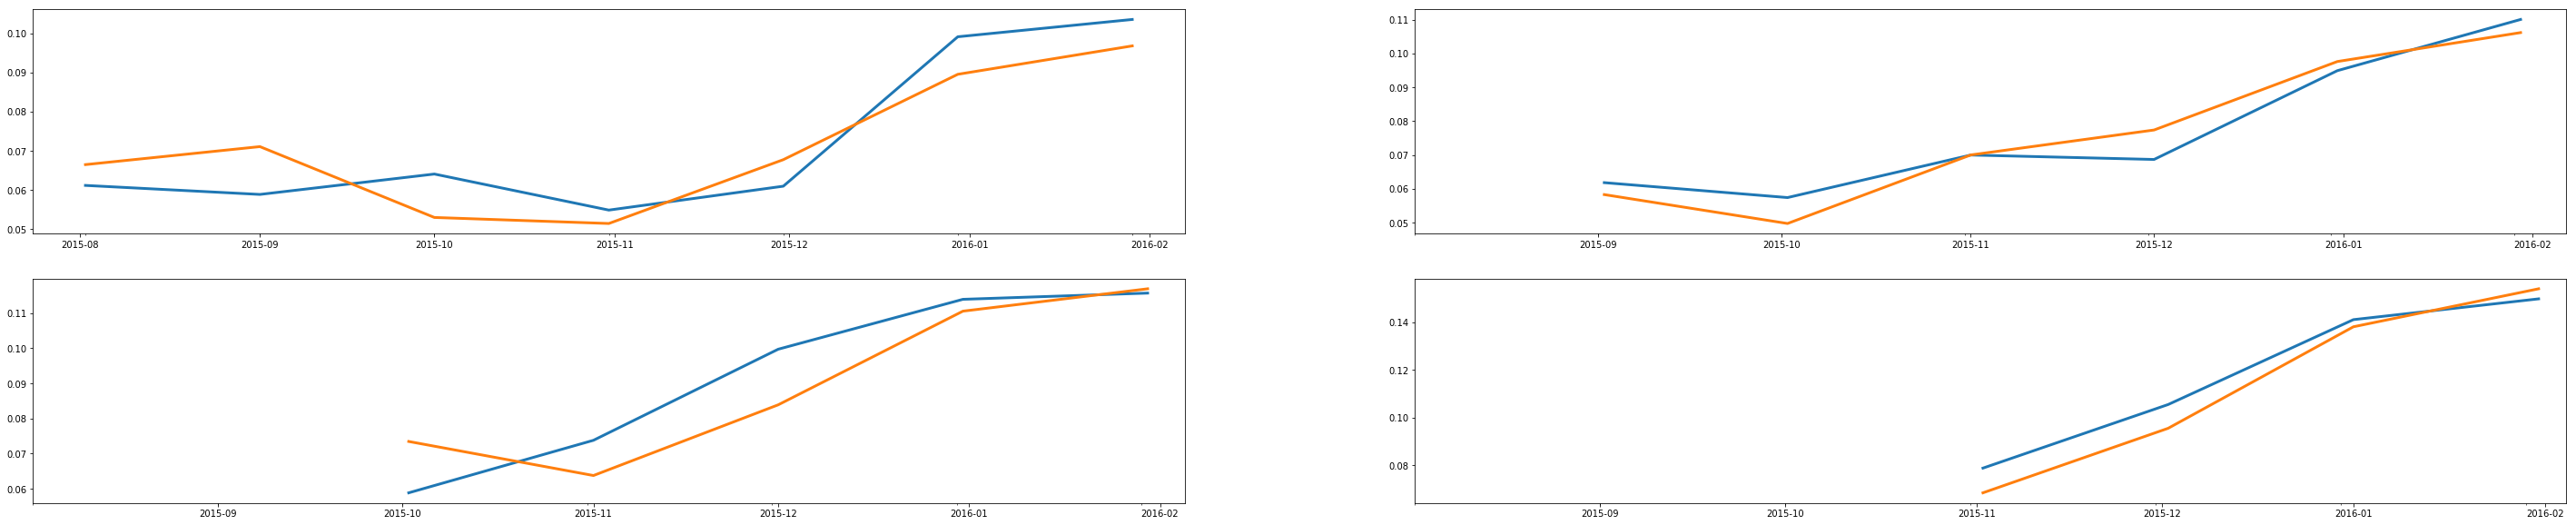

In [188]:
all_dates = [pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=day) for day in np.arange(start_times[0], 230+inter_time_jumps, inter_time_jumps)]


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(50, 10))  # , sharey=True)

for i, start_time in enumerate(start_times):
    # Get start date
    start_date = pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=start_time - 1)
    
    # Get intervention dates
    inter_dates = [pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=day)
                   for day in np.arange(start_time, 230+inter_time_jumps, inter_time_jumps)]

    # Get intervention results - attack rate
    inter_infection_rates = {}
    infect_rate_errs = {}
    for j, inter_per in enumerate(inter_percents):
        inter_infection_rates = [inter_res['attack_rates']['total'] for inter_res in inter_results[inter_per][start_time]]
        axs[i//2,i%2].plot(inter_dates, inter_infection_rates, linewidth=3, label=f'{start_date.month_name()} $1^{{st}}$', color=f'C{j}')
        
        # xticks
        axs[i//2,i%2].set_xticks(all_dates, [date.date() for date in all_dates])
        
#         inter_infection_rates[inter_per] = [inter_res['attack_rates']['total']
#                                             for inter_res in inter_results[inter_per][start_time]]
#         # Get errors
#         infect_rate_errs[inter_per] = [inter_res['attack_rates']['total_std']
#                                       for inter_res in inter_results[inter_per][start_time]]
    


In [175]:
# for i, inter_res in enumerate(inter_results):
#     print(f'Intervention time: day {inter_times[i]}')
#     print(f'Vaccination Coverage: {inter_res[1]["total"]*100:.2f}%')
#     print(f'Effective vaccination Coverage: {inter_res[2]*100:.2f}%')
#     print(f'Infection rate: {inter_res[0]["total"]*100:.2f}%')
#     print('\n')

In [176]:
# No intervention
no_inter_infect_rate = no_inter_res[0]["total"]
no_inter_vacc_cover = no_inter_res[1]["total"]
no_inter_eff_vacc_cover = no_inter_res[2]

# Intervention
inter_dates = [pd.Timestamp(season - 1, 6, 1) + pd.Timedelta(days=day) for day in inter_times]
inter_infection_rates = [inter_res[0]["total"] for inter_res in inter_results]
inter_vacc_coverage = [inter_res[1]["total"] for inter_res in inter_results]
inter_eff_vacc_coverage = [inter_res[2] for inter_res in inter_results]

# Direct effect
direct_infect_rate_decrease = no_inter_infect_rate - (np.array(inter_eff_vacc_coverage) - no_inter_eff_vacc_cover)
direct_vacc_cover_increase = no_inter_vacc_cover + percent

Plot infection rates

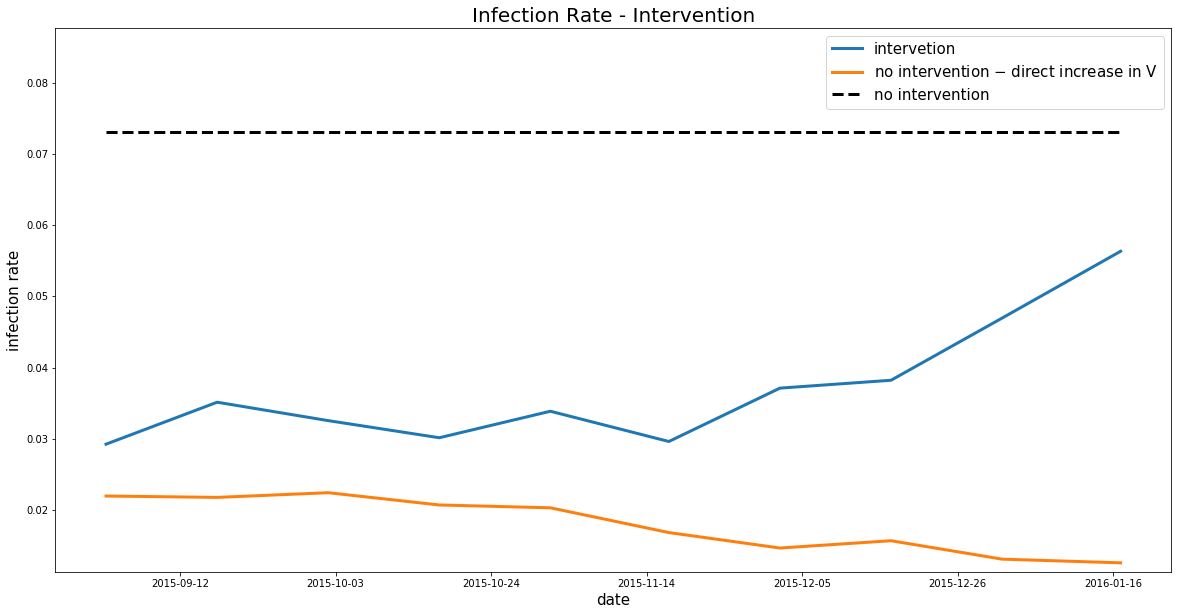

In [177]:
plt.figure(figsize=(20, 10))

# Plot intervention
plt.plot(inter_dates, inter_infection_rates, linewidth=3, label='intervetion')

# Plot direct effect
plt.plot(inter_dates, direct_infect_rate_decrease, linewidth=3, label='no intervention $-$ direct increase in V')


# Plot no intervention line
no_inter_line = plt.hlines(no_inter_infect_rate, inter_dates[0], inter_dates[-1], linestyle='--', linewidth=3,
                           label='no intervention')

plt.title('Infection Rate - Intervention', size=20)
plt.xlabel('date', size=15)
plt.ylabel('infection rate', size=15)
plt.ylim([min(inter_infection_rates+list(direct_infect_rate_decrease))*0.9,
          max(inter_infection_rates+list(direct_infect_rate_decrease)+[no_inter_infect_rate])*1.2])
plt.legend(fontsize=15)
# plt.legend([no_inter_line], ['no intervention'], fontsize=15)

plt.show()

Plot vaccination coverage

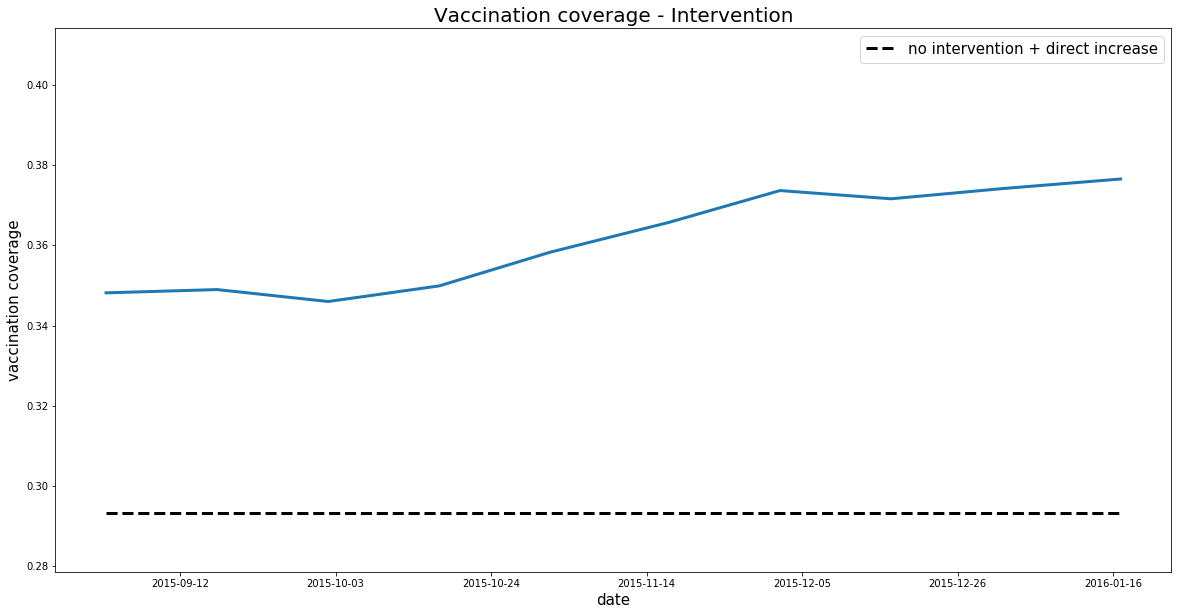

In [178]:
plt.figure(figsize=(20, 10))

plt.plot(inter_dates, inter_vacc_coverage, linewidth=3)

# Plot no intervention line
no_inter_vacc_cover = no_inter_res[1]["total"]
direct_vacc_cover_increase = no_inter_vacc_cover + percent
no_inter_line = plt.hlines(direct_vacc_cover_increase, inter_dates[0], inter_dates[-1], linestyle='--', linewidth=3,
                           label='no intervention + direct increase')

plt.title('Vaccination coverage - Intervention', size=20)
plt.xlabel('date', size=15)
plt.ylabel('vaccination coverage', size=15)
plt.ylim([min(inter_vacc_coverage+[direct_vacc_cover_increase])*0.95, max(inter_vacc_coverage+[no_inter_vacc_cover])*1.1])

plt.legend([no_inter_line], ['no intervention + direct increase'], fontsize=15)

plt.show()

Single

In [37]:
inter = {'time': 93, 'percent': 0.1, 'len': 1}
model_res_inter = model.run_coupled_model(parameters_i, parameters_v, prep_data, season, intervention=inter)

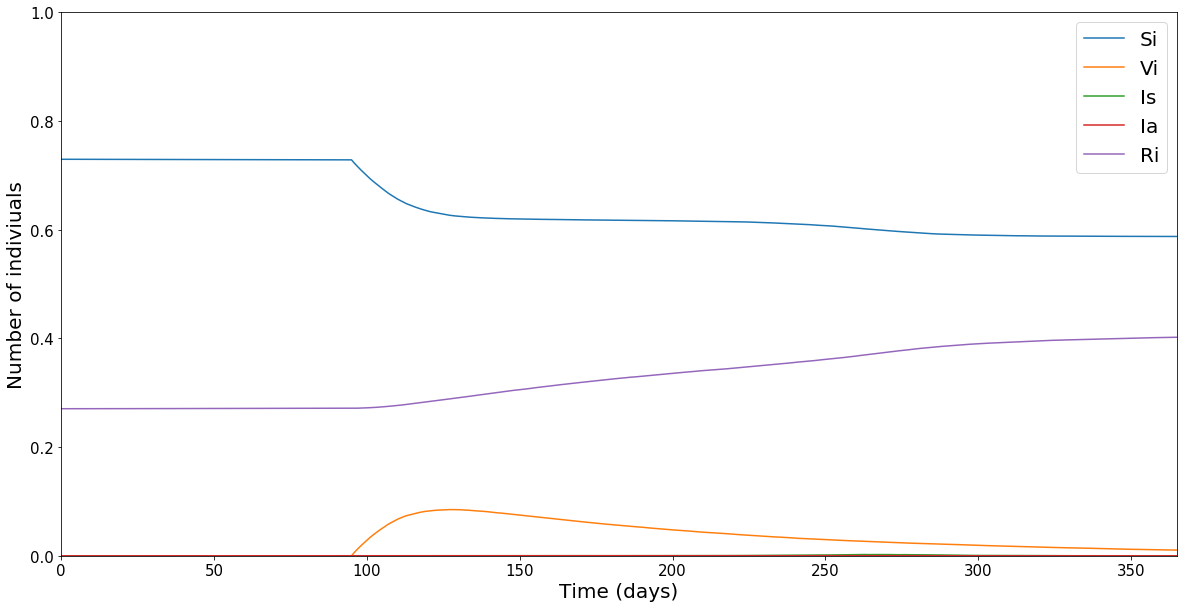

In [38]:
model.plot_model_states(model_res_inter, prep_data)

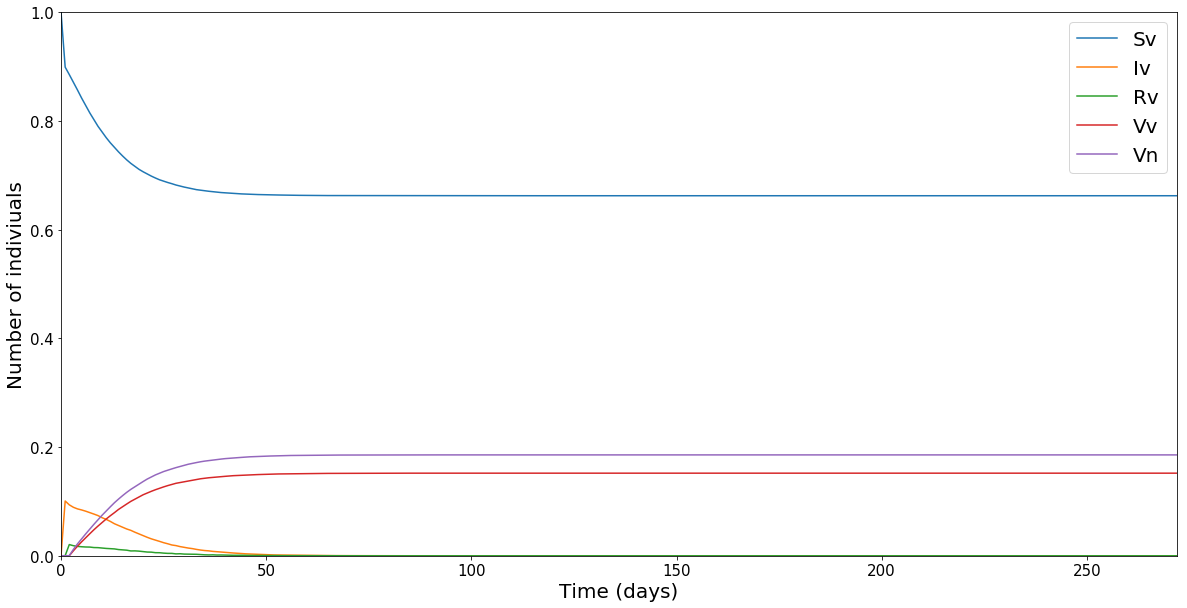

In [55]:
model.plot_model_states_vacc(model_res_inter, prep_data)

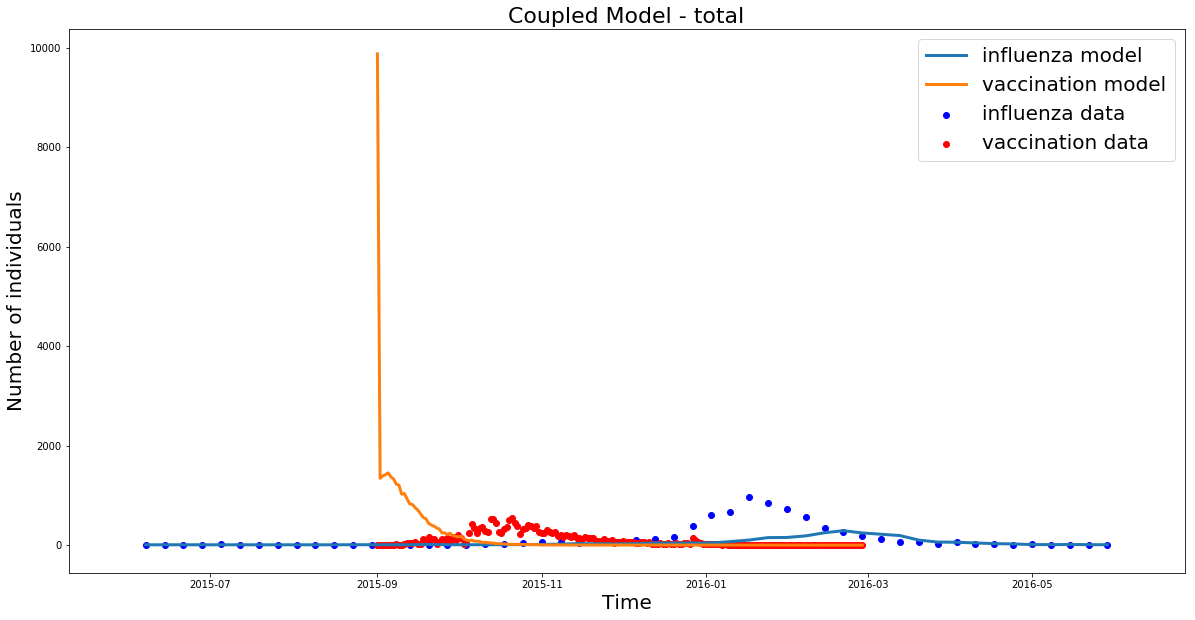

In [40]:
model.plot_aggregated_fit_coupled(model_res_inter, data_for_fit_i, data_for_fit_v, season)

In [28]:
def plot_model_states_vacc(model_results, prep_data):
    # Load states
    Sv = model_results['Sv']
    Iv = model_results['Iv']
    Rv = model_results['Rv']
    Vv = model_results['Vv']
    Vn = model_results['Vn']

    # Network size
    N = prep_data['N']

    Sv_sizes_norm = np.array([len(st) / N for st in Sv])
    Iv_sizes_norm = np.array([len(st) / N for st in Iv])
    Rv_sizes_norm = np.array([len(st) / N for st in Rv])
    Vv_sizes_norm = np.array([len(st) / N for st in Vv])
    Vn_sizes_norm = np.array([len(st) / N for st in Vn])

    ts = np.arange(len(Sv))
    plt.figure(figsize=(20, 10))
    plt.plot(ts, Sv_sizes_norm, label='Sv')
    plt.plot(ts, Iv_sizes_norm, label='Iv')
    plt.plot(ts, Rv_sizes_norm, label='Rv')
    plt.plot(ts, Vv_sizes_norm, label='Vv')
    plt.plot(ts, Vn_sizes_norm, label='Vn')


    # plt.title()

    plt.xlabel('Time (days)', size=20)
    plt.ylabel('Number of indiviuals', size=20)

    plt.xlim([0, len(Sv)-1])
    plt.xticks(ts[::50], size=15)

    # plt.ylim([0,100000])
    # plt.yticks(np.arange(0,120000,20000), size=15)
    plt.ylim([0, 1])
    plt.yticks(np.arange(0, 1.2, 0.2), size=15)

    plt.legend(fontsize=20, loc='upper right')
    plt.show()

In [ ]:
initialize_vaccination_model = model.initialize_vaccination_model
initialize_influenza_model = model.initialize_influenza_model

def run_coupled_model(parameters_i, parameters_v, prep_data, season, short=False, intervention=None):
    ##############################
    # ----- Initialization ----- #
    ##############################
    # Get influenza model parameters
    beta_i = parameters_i[season]['beta']
    delta_i = [parameters_i[season]['delta'], 1]
    phi = parameters_i[season]['phi']
    I_0_size_i = 0  # parameters[season]['I_0_size']
    epsilon = parameters_i[season]['epsilon']

    # Get vaccination model parameters
    beta_v = parameters_v['beta']
    delta_v = [parameters_v['delta'], 1]
    gamma_v = parameters_v['gamma']
    I_0_size_v = parameters_v['I_0_size']

    # Get prep data
    network, relevant_clinics_age, node_clinic_age = prep_data['network'], prep_data['relevant_clinics_age'], \
                                                     prep_data['node_clinic_age']
    # nodes_by_clinic_age = prep_data['nodes_by_clinic_age']
    # vaccination_coverage_influenza = prep_data['vaccination_coverage_influenza']
    # population_by_clinic_age = prep_data['population_by_clinic_age']

    # Set season length
    season_length = 274 if short else 365
    # season_length = 244 if short else 365

    # Influenza vaccination efficacy
    vaccination_efficacy = 0.1

    # Influenza vaccination delay (in days)
    vacc_delay = 14

    # Vaccination waning (111 days)
    omega = 1 / 111

    # Asymptomatic fraction
    asymp_frac = 0.191

    # Transmissibility - based on log viral load according to infection type (symptomatic/asymptomatic)
    rho_symp = 5.5
    rho_asym = 4.5

    # Cross reactivity rate - by age group TODO: CHECK!!!
    # cross_reactivity = [0.2, 0.3]

    # Recovery rate - symptomatic
    gamma_symp = [0.1477929674216146, 1 / 4.5]
    # Recovery rate - asymptomatic
    gamma_asymp = 1 / 3.2

    # Initialize vaccination model
    vacc_model = initialize_vaccination_model(parameters_v, prep_data)
    # Vaccination model states
    Sv, Iv, Rv, Vv = vacc_model['S'], vacc_model['I'], vacc_model['R'], [set()]
    # Newly infected
    new_Iv, new_Iv_by_age = vacc_model['new_I'], vacc_model['new_I_by_age']

    # Initialize influenza model
    flu_model = initialize_influenza_model(prep_data)
    # Influenza model states
    Si, Vi, Is, Ia, Ri, Rs = flu_model['S'], flu_model['V'], flu_model['Is'], flu_model['Ia'], flu_model['R'], flu_model['Rs']
    # Newly infected
    new_Is, new_Is_by_age, Is_by_clinic_age = flu_model['new_Is'], flu_model['new_Is_by_age'], flu_model['Is_by_clinic_age']
    # Lambdas
    lambdas, lambdas_agg_total, lambdas_agg_children, lambdas_agg_adult = flu_model['lambdas'], flu_model['lambdas_agg_total'], \
                                                                          flu_model['lambdas_agg_children'], flu_model['lambdas_agg_adult']

    # Intervention - if not intervention - set all to None
    if intervention is None:
        intervention = {'time': None, 'percent': None, 'len': None, 'range': []}

    else:
        # Intervention size per day
        intervention['size'] = int(round((prep_data['N'] * intervention['percent']) / intervention['len']))
        # Intervention range of days
        intervention['range'] = np.arange(intervention['time'], intervention['time'] + intervention['len'])

    #############################
    # ------- Run Model ------- #
    #############################

    # for t in tqdm(range(season_length)):
    for t in (range(season_length)):
        # Vaccination model newly infected
        new_Iv_t = set()
        new_Rv_t = set()
        new_V_t = set()
        new_Iv_by_age_t = [set(), set()]

        # Influenza model newly infected
        new_Ia_t = set()
        new_Is_t = set()
        new_Is_by_age_t = [set(), set()]
        new_R_t = set()
        new_Rs_t = set()

        # Intervention
        if t in intervention['range']:
            # Choose nodes to infect (randomly)
            intervention_nodes = set(np.random.choice(list(Sv[-1]), replace=False, size=intervention['size']))
            # Infect the nodes (with the idea of vaccination)
            for node in intervention_nodes:
                # Get node's age
                cur_age = node_clinic_age[node][1]
                # Add to new Iv
                new_Iv_t.add(node)
                new_Iv_by_age_t[cur_age].add(node)

        # --- Vaccination "infection" --- #
        # Only if within vaccination season (after the beginning)
        if t > 92:  # From September 1st
            # Go over the infected (vaccinated) nodes
            for node in Iv[-1]:
                for contact in network[node]:
                    # If the contact is susceptible and not exposed in this stage yet
                    if contact in Sv[-1] and contact not in new_Iv_t:
                        # Get age and clinic
                        cur_clinic, cur_age = node_clinic_age[contact]
                        # Contact is exposed with probability beta_2 * delta
                        if np.random.rand() < beta_v * delta_v[cur_age]:
                            new_Iv_t.add(contact)
                            new_Iv_by_age_t[cur_age].add(contact)

            # Transmission from Iv to Rv
            for node in Iv[-1]:
                # Individuals transmitted from Iv to Rv with probability gamma
                new_Rv_t.add(node) if np.random.rand() < gamma_v else None

            # Transmission from Rv to V
            for node in Rv[-1]:
                # Individuals transmitted from Rv to V with probability 1/vaccine_delay
                if np.random.rand() < vacc_delay:
                    # Individuals are transmitted to V only if the vaccine is effective (with probability of vaccination_efficacy)
                    if np.random.rand() < vaccination_efficacy:
                        new_V_t.add(node)

            # Update stages
            Sv.append(Sv[-1] - new_Iv_t)
            Iv.append(Iv[-1].union(new_Iv_t) - new_Rv_t)
            Rv.append(Rv[-1].union(new_Rv_t) - new_V_t)
            Vv.append(Rv[-1].union(new_V_t))

            # Save the newly infected
            new_Iv.append(new_Iv_t)
            new_Iv_by_age[0].append(new_Iv_by_age_t[0])
            new_Iv_by_age[1].append(new_Iv_by_age_t[1])

        # --- Influenza infection --- #
        # Go over the infected individuals
        for i, node in enumerate(list(Is[-1]) + list(Ia[-1])):
            for contact in network[node]:
                # If the contact is susceptible and not exposed in this stage yet
                if contact in Si[-1] and contact not in new_Is_t and contact not in new_Ia_t:
                    # Get age and clinic
                    cur_clinic, cur_age = node_clinic_age[contact]
                    # Get relevant transmissability (rho)
                    rho = rho_symp if i < len(Is[-1]) else rho_asym
                    # Force of infection
                    force_of_infection = beta_i * delta_i[cur_age] * rho * (1 + np.cos((2 * np.pi * t) / 365 + phi))
                    # Contact is infected with probability according to the force of infection
                    if np.random.rand() < force_of_infection:
                        # Generate infection type
                        infection_type = 'asymptomatic' if np.random.rand() < asymp_frac else 'symptomatic'
                        if infection_type == 'symptomatic':
                            new_Is_t.add(contact)
                            new_Is_by_age_t[cur_age].add(contact)
                            Is_by_clinic_age[(cur_clinic, cur_age)][t] += 1
                        elif infection_type == 'asymptomatic':
                            new_Ia_t.add(contact)
                    # Update lambda_kt
                    lambdas[(cur_clinic, cur_age)][t] += force_of_infection * (1 - asymp_frac)
                    lambdas_agg_total[t] += force_of_infection * (1 - asymp_frac)
                    if cur_age == 0:
                        lambdas_agg_children[t] += force_of_infection * (1 - asymp_frac)
                    else:
                        lambdas_agg_adult[t] += force_of_infection * (1 - asymp_frac)

        # Add "epsilon" - constant infection of 5 random nodes each day
        if len(Si[-1] - new_Is_t - new_Ia_t) <= epsilon:
            epsilon_nodes = Si[-1] - new_Is_t - new_Ia_t
        else:
            epsilon_nodes = set(np.random.choice(list(Si[-1] - new_Is_t - new_Ia_t), epsilon, replace=False))
        for i, node in enumerate(epsilon_nodes):
            # Get age and clinic
            cur_clinic, cur_age = node_clinic_age[node]
            if i < 4:
                new_Is_t.add(node)
                new_Is_by_age_t[cur_age].add(node)
            else:
                new_Ia_t.add(node)

        # Transmission from I to R
        for i, node in enumerate(list(Is[-1]) + list(Ia[-1])):
            # Get infection type
            infection_type = 'symptomatic' if i < len(Is[-1]) else 'asymptomatic'
            # Get individual's age
            cur_age = node_clinic_age[node][1]
            # Get relevant gamma according to infection type and individual age
            if infection_type == 'symptomatic':
                gamma_i = gamma_symp[cur_age]
            elif infection_type == 'asymptomatic':
                gamma_i = gamma_asymp
            # Individuals transmitted from I to R with probability gamma - according to infection type and age
            if np.random.rand() < gamma_i:
                new_R_t.add(node)
                if infection_type == 'symptomatic':
                    new_Rs_t.add(node)

        # Transmission form V to R
        for node in Vi[-1]:
            # Individuals transmitted from Iv to Rv with probability gamma
            new_R_t.add(node) if np.random.rand() < omega else None

        # Update stages
        Si.append(Si[-1] - new_Is_t - new_Ia_t - new_V_t)
        Vi.append(Vi[-1].union(new_V_t - Ri[0]) - new_R_t)  # Do not add immuned nodes
        Is.append(Is[-1].union(new_Is_t) - new_R_t)
        Ia.append(Ia[-1].union(new_Ia_t) - new_R_t)
        Ri.append(Ri[-1].union(new_R_t))
        Rs.append(Rs[-1].union(new_Rs_t))

        # Save the newly infected
        new_Is.append(new_Is_t)
        new_Is_by_age[0].append(new_Is_by_age_t[0])
        new_Is_by_age[1].append(new_Is_by_age_t[1])

    # Save results to dictionary
    model_results = {'Sv': Sv, 'Iv': Iv, 'Rv': Rv, 'Vv': Vv,  # Vaccination model states
                     'new_Iv': new_Iv, 'new_Iv_by_age': new_Iv_by_age,  # Vaccination model newly infected
                     'Si': Si, 'Vi': Vi, 'Is': Is, 'Ia': Ia, 'Ri': Ri, 'Rs': Rs,  # Influenza model states
                     'new_Is': new_Is, 'new_Is_by_age': new_Is_by_age, 'Is_by_clinic_age': Is_by_clinic_age,  # Influenza model newly infected
                     'lambdas': lambdas, 'lambdas_agg_total': lambdas_agg_total, 'lambdas_agg_children': lambdas_agg_children,  # lambdas
                     'lambdas_agg_adult': lambdas_agg_adult}

    return model_results